In [1]:
from IPython.display import clear_output
from typing import List, Optional

import datetime
import gpflow as gpf
import hydra
import matplotlib.pyplot as plt
import numpy as np
import os
import palettable
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import cm
from modeopt.custom_types import Dataset
from modeopt.utils import model_from_DictConfig
from modeopt.mode_opt import ModeOpt
from mogpe.keras.callbacks.tensorboard import PlotFn, TensorboardImageCallback
from mogpe.keras.mixture_of_experts import MixtureOfSVGPExperts
from mogpe.keras.plotting import MixtureOfSVGPExpertsContourPlotter
from mogpe.keras.utils import sample_mosvgpe_inducing_inputs_from_data, model_from_yaml
from numpy import random
from omegaconf import DictConfig
from simenvs import make

tfd = tfp.distributions

CMAP = palettable.scientific.sequential.Bilbao_15.mpl_colormap

meaning_of_life = 42
tf.random.set_seed(meaning_of_life)
np.random.seed(meaning_of_life)

In [2]:
env_name = "velocity-controlled-point-mass/scenario-5"
start_state = np.array([2.5, -1.2])
target_state = np.array([-3.0, 2.5])
env_name = "velocity-controlled-point-mass/scenario-7"
target_state = np.array([1.7, 3.0])
start_state = np.array([-1.0, -2.0])
num_initial_states = 30

In [3]:
# mode_satisfaction_prob = 0.8
mode_satisfaction_prob = 0.8
# mode_satisfaction_prob = 0.4

In [4]:
now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M') #  now
save_dir = os.path.join("./images/", str(mode_satisfaction_prob))
save_dir = os.path.join(save_dir, now_time)
os.makedirs(save_dir)

In [5]:
initial_num_epochs = 1300
num_epochs = 150
batch_size = 16

In [6]:
env = make(env_name)
state_dim = env.observation_spec().shape[0]

No constant_error found in toml config so using default : 0.0


In [7]:
def get_initial_states(start_state, target_state, width):
    return random.uniform([start_state[0]-width, start_state[1]-width],
                                   [start_state[0]+width, start_state[1]+width],
                                    (num_initial_states, state_dim))
initial_states = get_initial_states(start_state, target_state, width=1.0)
# initial_states = random.uniform([2, -2], [3, -1], (num_initial_states, state_dim))

In [8]:
yaml_cfg_filename = "./velocity_controlled_point_mass/notebooks/keras_configs/dynamics.yaml"
# yaml_cfg_filename = "./notebooks/keras_configs/dynamics.yaml"
yaml_cfg_filename = "./keras_configs/dynamics.yaml"
mode_optimiser = model_from_yaml(yaml_cfg_filename, custom_objects={"ModeOpt": ModeOpt})

╒════════════════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════╤═════════╤════════════════════════════════════════╕
│ name                                                           │ class     │ transform      │ prior   │ trainable   │ shape       │ dtype   │ value                                  │
╞════════════════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════╪═════════╪════════════════════════════════════════╡
│ IndependentPosteriorMultiOutput.kernel.kernels[0].variance     │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.0                                    │
├────────────────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼────────────────────────────────────────┤
│ IndependentPosteriorMultiOutput.kernel.kernels[0].lengthscales │ Paramete

2022-02-27 21:52:58.473712: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-27 21:52:58.674069: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-27 21:52:58.674082: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-27 21:52:58.674108: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [9]:
def sample_env_at_states(states, num_actions=5, verbose=False):
    delta_state_outputs = []
    state_control_inputs = []
    for state in states:
        for i in range(num_actions):
            action = np.random.uniform(env.action_spec().minimum, 
                                       env.action_spec().maximum, 
                                       (env.action_spec().shape[-1]))
            delta_state = env.transition_dynamics(state, action)
            delta_state_outputs.append(delta_state)
            state_control_input = np.concatenate([state, action], -1)
            state_control_inputs.append(state_control_input)
    delta_state_outputs = np.stack(delta_state_outputs)
    state_control_inputs = np.stack(state_control_inputs)
    if verbose:
        print("State control inputs: ", state_control_inputs.shape)
        print("Delta state outputs: ", delta_state_outputs.shape)
    return state_control_inputs, delta_state_outputs

initial_dataset = sample_env_at_states(initial_states, verbose=True)
dataset = initial_dataset

State control inputs:  (150, 4)
Delta state outputs:  (150, 2)


In [10]:
mode_optimiser.dataset = initial_dataset
sample_mosvgpe_inducing_inputs_from_data(initial_dataset[0], mode_optimiser.dynamics.mosvgpe)
num_experts = mode_optimiser.dynamics.mosvgpe.num_experts

In [11]:
def create_test_inputs(
    x_min=[-3, -3], x_max=[3, 3], input_dim=4, num_test: int = 400, factor: float = 1.2
):
    sqrtN = int(np.sqrt(num_test))
    xx = np.linspace(x_min[0] * factor, x_max[0] * factor, sqrtN)
    yy = np.linspace(x_min[1] * factor, x_max[1] * factor, sqrtN)
    xx, yy = np.meshgrid(xx, yy)
    test_inputs = np.column_stack([xx.reshape(-1), yy.reshape(-1)])
    if input_dim > 2:
        zeros = np.zeros((num_test, input_dim - 2))
        test_inputs = np.concatenate([test_inputs, zeros], -1)
    return test_inputs, xx, yy
test_inputs, xx, yy = create_test_inputs()

In [12]:
def plot_states(ax, states):
    ax.scatter(states[:, 0], states[:, 1], marker='x', color='b', alpha=0.4, label="Observations")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_xlim([-3.5, 3.5])
    ax.set_ylim([-3.5, 3.5])
    ax.scatter(start_state[0], start_state[1], color="k", marker="s")
    ax.scatter(target_state[0], target_state[1], color="k", marker="s")
    ax.annotate("$\mathbf{x}_0$", (start_state[0] + 0.1, start_state[1]))
    ax.annotate("$\mathbf{x}_f$", (target_state[0] - 0.35, target_state[1]))

# def plot_gating_network_gps(states):
#     fig = plt.figure(figsize=(15,10))
#     gs = fig.add_gridspec(num_experts, 2, wspace=0.3)
#     axs = gs.subplots(sharex=True, sharey=True)
#     fig.suptitle("Gating GPs")
#     h_means, h_vars = mode_optimiser.dynamics.mosvgpe.gating_network.predict_h(test_inputs)
#     mixing_probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs(test_inputs)
#     delta_mode_inputs = test_inputs[mixing_probs[:, desired_mode]>mode_satisfaction_prob]
#     print(delta_mode_inputs.shape)
#     for k in range(num_experts):
#         axs[k, 0].tricontourf(test_inputs[:, 0], test_inputs[:, 1], h_means[:, k], cmap=CMAP)
#         axs[k, 1].tricontourf(test_inputs[:, 0], test_inputs[:, 1], h_vars[:, k], cmap=CMAP)
#         for ax in axs[k, :].flat:
#             CS = ax.contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
#             ax.clabel(CS, inline=True, fontsize=10)
#     for ax in axs.flat:
# #         ax.tricontourf(delta_mode_inputs[:, 0], 
# #                        delta_mode_inputs[:, 1], 
# #                        np.zeros(delta_mode_inputs.shape[0]), 
# #                        cmap=cm.PiYG)
#         plot_states(ax, states)

# plot_gating_network_gps(initial_states)

/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.sha

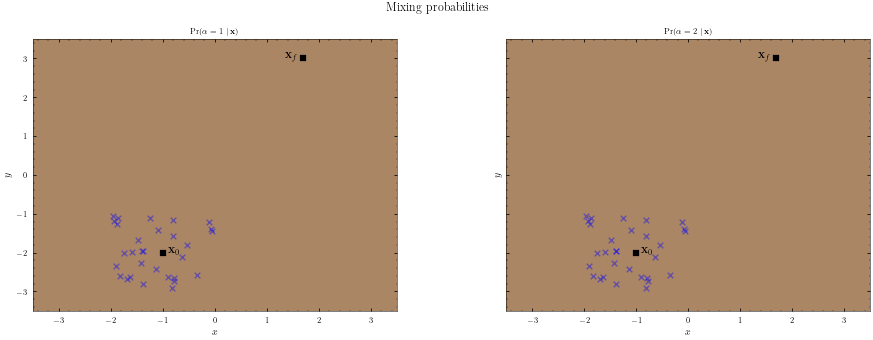

In [13]:
def plot_mixing_probs(states):
    fig = plt.figure(figsize=(15,5))
    fig.suptitle("Mixing probabilities")
    gs = fig.add_gridspec(1, num_experts, wspace=0.3)
    axs = gs.subplots(sharex=True, sharey=True)
    mixing_probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs(test_inputs)
    for k in range(num_experts):
        axs[k].tricontourf(test_inputs[:, 0], test_inputs[:, 1], mixing_probs[:, k], cmap=CMAP)
        CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
        axs[k].clabel(CS, inline=True, fontsize=10)
        axs[k].set_title("$\Pr(\\alpha=" + str(k + 1) + " \mid \mathbf{x})$")
        plot_states(axs[k], states)

plot_mixing_probs(initial_states)
# plt.savefig("./velocity_controlled_point_mass/notebooks/images/initial_mixing_probs.pdf", transparent=True)
plt.savefig(os.path.join(save_dir, "initial_mixing_probs_before_training.pdf"), transparent=True)

In [14]:
mode_optimiser.dynamics.fit(initial_dataset[0], initial_dataset[1], epochs=initial_num_epochs, batch_size=batch_size)
initial_mosvgpe = MixtureOfSVGPExperts.from_config(mode_optimiser.dynamics.mosvgpe.get_config())

2022-02-27 21:53:00.673010: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1300
Mixing probs: (1, None, 2)
Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Experts probs: (None, None, 2)


2022-02-27 21:53:04.485104: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Mixing probs: (1, None, 2)
Experts probs: (None, None, 2)
10/10 [==============================] - 15s 9ms/step - loss: 30265446.5815
Epoch 2/1300
10/10 [==============================] - 0s 7ms/step - loss: 18433705.1154
Epoch 3/1300
10/10 [==============================] - 0s 7ms/step - loss: 10987357.4298
Epoch 4/1300
10/10 [==============================] - 0s 8ms/step - loss: 6277654.6646
Epoch 5/1300
10/10 [==============================] - 0s 7ms/step - loss: 3499440.6408
Epoch 6/1300
10/10 [==============================] - 0s 7ms/step - loss: 1961879.3484
Epoch 7/1300
10/10 [==============================] - 0s 8ms/step - loss: 1130301.1821
Epoch 8/1300
10/10 [==============================] - 0s 7ms/step - loss: 662174.5848
Epoch 9/1300
10/10 [==============================] - 0s 8ms/step - loss: 399125.6105
Epoch 10/1300
10/10 [==============================] - 0s 8ms/step - loss: 254649.7455
Epoch 11/1300
10/10 [==============================] - 0s 8ms/step - loss: 173805.3

10/10 [==============================] - 0s 7ms/step - loss: 1606.7180
Epoch 95/1300
10/10 [==============================] - 0s 7ms/step - loss: 1605.0548
Epoch 96/1300
10/10 [==============================] - 0s 7ms/step - loss: 1574.0182
Epoch 97/1300
10/10 [==============================] - 0s 7ms/step - loss: 1501.7559
Epoch 98/1300
10/10 [==============================] - 0s 7ms/step - loss: 1513.6855
Epoch 99/1300
10/10 [==============================] - 0s 7ms/step - loss: 1481.1186
Epoch 100/1300
10/10 [==============================] - 0s 7ms/step - loss: 1438.8726
Epoch 101/1300
10/10 [==============================] - 0s 7ms/step - loss: 1422.9075
Epoch 102/1300
10/10 [==============================] - 0s 7ms/step - loss: 1375.5123
Epoch 103/1300
10/10 [==============================] - 0s 7ms/step - loss: 1373.5846
Epoch 104/1300
10/10 [==============================] - 0s 7ms/step - loss: 1361.9149
Epoch 105/1300
10/10 [==============================] - 0s 7ms/step - loss

10/10 [==============================] - 0s 7ms/step - loss: 577.9137
Epoch 191/1300
10/10 [==============================] - 0s 8ms/step - loss: 556.0339
Epoch 192/1300
10/10 [==============================] - 0s 7ms/step - loss: 562.6669
Epoch 193/1300
10/10 [==============================] - 0s 8ms/step - loss: 572.1811
Epoch 194/1300
10/10 [==============================] - 0s 8ms/step - loss: 528.3516
Epoch 195/1300
10/10 [==============================] - 0s 8ms/step - loss: 506.5025
Epoch 196/1300
10/10 [==============================] - 0s 8ms/step - loss: 513.7009
Epoch 197/1300
10/10 [==============================] - 0s 8ms/step - loss: 545.7463
Epoch 198/1300
10/10 [==============================] - 0s 9ms/step - loss: 528.5455
Epoch 199/1300
10/10 [==============================] - 0s 9ms/step - loss: 544.2717
Epoch 200/1300
10/10 [==============================] - 0s 10ms/step - loss: 555.2900
Epoch 201/1300
10/10 [==============================] - 0s 10ms/step - loss: 52

10/10 [==============================] - 0s 8ms/step - loss: 253.5374
Epoch 287/1300
10/10 [==============================] - 0s 8ms/step - loss: 263.5043
Epoch 288/1300
10/10 [==============================] - 0s 8ms/step - loss: 243.6340
Epoch 289/1300
10/10 [==============================] - 0s 8ms/step - loss: 244.2438
Epoch 290/1300
10/10 [==============================] - 0s 8ms/step - loss: 264.8892
Epoch 291/1300
10/10 [==============================] - 0s 8ms/step - loss: 267.7005
Epoch 292/1300
10/10 [==============================] - 0s 8ms/step - loss: 240.0372
Epoch 293/1300
10/10 [==============================] - 0s 8ms/step - loss: 235.8364
Epoch 294/1300
10/10 [==============================] - 0s 9ms/step - loss: 264.1178
Epoch 295/1300
10/10 [==============================] - 0s 8ms/step - loss: 235.9718
Epoch 296/1300
10/10 [==============================] - 0s 8ms/step - loss: 251.8657
Epoch 297/1300
10/10 [==============================] - 0s 9ms/step - loss: 243.

10/10 [==============================] - 0s 11ms/step - loss: 65.5881
Epoch 383/1300
10/10 [==============================] - 0s 11ms/step - loss: 64.1489
Epoch 384/1300
10/10 [==============================] - 0s 10ms/step - loss: 66.7868
Epoch 385/1300
10/10 [==============================] - 0s 10ms/step - loss: 103.1781
Epoch 386/1300
10/10 [==============================] - 0s 10ms/step - loss: 83.3781
Epoch 387/1300
10/10 [==============================] - 0s 12ms/step - loss: 93.5537
Epoch 388/1300
10/10 [==============================] - 0s 11ms/step - loss: 64.9265
Epoch 389/1300
10/10 [==============================] - 0s 10ms/step - loss: 78.1991
Epoch 390/1300
10/10 [==============================] - 0s 10ms/step - loss: 75.6477
Epoch 391/1300
10/10 [==============================] - 0s 11ms/step - loss: 58.9019
Epoch 392/1300
10/10 [==============================] - 0s 11ms/step - loss: 92.8110
Epoch 393/1300
10/10 [==============================] - 0s 11ms/step - loss: 61

10/10 [==============================] - 0s 11ms/step - loss: -27.5378
Epoch 479/1300
10/10 [==============================] - 0s 11ms/step - loss: -58.0282
Epoch 480/1300
10/10 [==============================] - 0s 11ms/step - loss: -47.7413
Epoch 481/1300
10/10 [==============================] - 0s 11ms/step - loss: -69.3704
Epoch 482/1300
10/10 [==============================] - 0s 11ms/step - loss: -67.8551
Epoch 483/1300
10/10 [==============================] - 0s 11ms/step - loss: -53.0384
Epoch 484/1300
10/10 [==============================] - 0s 11ms/step - loss: -28.4790
Epoch 485/1300
10/10 [==============================] - 0s 11ms/step - loss: 19.1082
Epoch 486/1300
10/10 [==============================] - 0s 12ms/step - loss: -26.8381
Epoch 487/1300
10/10 [==============================] - 0s 12ms/step - loss: -24.0415
Epoch 488/1300
10/10 [==============================] - 0s 12ms/step - loss: -67.9533
Epoch 489/1300
10/10 [==============================] - 0s 13ms/step -

Epoch 573/1300
10/10 [==============================] - 0s 14ms/step - loss: -144.7158
Epoch 574/1300
10/10 [==============================] - 0s 14ms/step - loss: -127.5681
Epoch 575/1300
10/10 [==============================] - 0s 14ms/step - loss: -166.5452
Epoch 576/1300
10/10 [==============================] - 0s 14ms/step - loss: -171.0877
Epoch 577/1300
10/10 [==============================] - 0s 14ms/step - loss: -178.5429
Epoch 578/1300
10/10 [==============================] - 0s 14ms/step - loss: -120.2103
Epoch 579/1300
10/10 [==============================] - 0s 14ms/step - loss: -92.7682
Epoch 580/1300
10/10 [==============================] - 0s 14ms/step - loss: -93.3264
Epoch 581/1300
10/10 [==============================] - 0s 14ms/step - loss: -134.3908
Epoch 582/1300
10/10 [==============================] - 0s 14ms/step - loss: -113.8763
Epoch 583/1300
10/10 [==============================] - 0s 14ms/step - loss: -125.0270
Epoch 584/1300
10/10 [=======================

10/10 [==============================] - 0s 16ms/step - loss: -183.5629
Epoch 668/1300
10/10 [==============================] - 0s 16ms/step - loss: -139.5765
Epoch 669/1300
10/10 [==============================] - 0s 16ms/step - loss: -185.4562
Epoch 670/1300
10/10 [==============================] - 0s 16ms/step - loss: -251.6580
Epoch 671/1300
10/10 [==============================] - 0s 16ms/step - loss: -265.1468
Epoch 672/1300
10/10 [==============================] - 0s 17ms/step - loss: -291.3762
Epoch 673/1300
10/10 [==============================] - 0s 16ms/step - loss: -284.7369
Epoch 674/1300
10/10 [==============================] - 0s 16ms/step - loss: -293.6417
Epoch 675/1300
10/10 [==============================] - 0s 16ms/step - loss: -258.1944
Epoch 676/1300
10/10 [==============================] - 0s 16ms/step - loss: -219.0219
Epoch 677/1300
10/10 [==============================] - 0s 16ms/step - loss: -222.0053
Epoch 678/1300
10/10 [==============================] - 0s

10/10 [==============================] - 0s 14ms/step - loss: -280.0704
Epoch 762/1300
10/10 [==============================] - 0s 14ms/step - loss: -296.8591
Epoch 763/1300
10/10 [==============================] - 0s 15ms/step - loss: -334.3520
Epoch 764/1300
10/10 [==============================] - 0s 15ms/step - loss: -336.1182
Epoch 765/1300
10/10 [==============================] - 0s 14ms/step - loss: -365.9690
Epoch 766/1300
10/10 [==============================] - 0s 15ms/step - loss: -338.9157
Epoch 767/1300
10/10 [==============================] - 0s 15ms/step - loss: -231.3666
Epoch 768/1300
10/10 [==============================] - 0s 15ms/step - loss: -237.6241
Epoch 769/1300
10/10 [==============================] - 0s 15ms/step - loss: -238.2282
Epoch 770/1300
10/10 [==============================] - 0s 14ms/step - loss: -225.5445
Epoch 771/1300
10/10 [==============================] - 0s 14ms/step - loss: -248.0061
Epoch 772/1300
10/10 [==============================] - 0s

10/10 [==============================] - 0s 13ms/step - loss: -230.0240
Epoch 856/1300
10/10 [==============================] - 0s 13ms/step - loss: -206.1179
Epoch 857/1300
10/10 [==============================] - 0s 13ms/step - loss: -252.0986
Epoch 858/1300
10/10 [==============================] - 0s 13ms/step - loss: -194.3667
Epoch 859/1300
10/10 [==============================] - 0s 13ms/step - loss: -191.9160
Epoch 860/1300
10/10 [==============================] - 0s 13ms/step - loss: -246.7307
Epoch 861/1300
10/10 [==============================] - 0s 13ms/step - loss: -264.0644
Epoch 862/1300
10/10 [==============================] - 0s 13ms/step - loss: -297.5347
Epoch 863/1300
10/10 [==============================] - 0s 13ms/step - loss: -249.7803
Epoch 864/1300
10/10 [==============================] - 0s 13ms/step - loss: -288.4033
Epoch 865/1300
10/10 [==============================] - 0s 13ms/step - loss: -301.2983
Epoch 866/1300
10/10 [==============================] - 0s

10/10 [==============================] - 0s 11ms/step - loss: -403.5070
Epoch 950/1300
10/10 [==============================] - 0s 11ms/step - loss: -413.3248
Epoch 951/1300
10/10 [==============================] - 0s 11ms/step - loss: -434.8839
Epoch 952/1300
10/10 [==============================] - 0s 11ms/step - loss: -406.0571
Epoch 953/1300
10/10 [==============================] - 0s 11ms/step - loss: -409.1429
Epoch 954/1300
10/10 [==============================] - 0s 11ms/step - loss: -425.0279
Epoch 955/1300
10/10 [==============================] - 0s 11ms/step - loss: -445.0108
Epoch 956/1300
10/10 [==============================] - 0s 11ms/step - loss: -342.4527
Epoch 957/1300
10/10 [==============================] - 0s 11ms/step - loss: -295.6796
Epoch 958/1300
10/10 [==============================] - 0s 11ms/step - loss: -210.2643
Epoch 959/1300
10/10 [==============================] - 0s 12ms/step - loss: -332.9298
Epoch 960/1300
10/10 [==============================] - 0s

10/10 [==============================] - 0s 11ms/step - loss: -240.5820
Epoch 1043/1300
10/10 [==============================] - 0s 11ms/step - loss: -297.1395
Epoch 1044/1300
10/10 [==============================] - 0s 11ms/step - loss: -368.2739
Epoch 1045/1300
10/10 [==============================] - 0s 11ms/step - loss: -372.2063
Epoch 1046/1300
10/10 [==============================] - 0s 11ms/step - loss: -414.8757
Epoch 1047/1300
10/10 [==============================] - 0s 12ms/step - loss: -362.7748
Epoch 1048/1300
10/10 [==============================] - 0s 11ms/step - loss: -427.4788
Epoch 1049/1300
10/10 [==============================] - 0s 12ms/step - loss: -450.5121
Epoch 1050/1300
10/10 [==============================] - 0s 12ms/step - loss: -456.8386
Epoch 1051/1300
10/10 [==============================] - 0s 13ms/step - loss: -476.2358
Epoch 1052/1300
10/10 [==============================] - 0s 12ms/step - loss: -467.8906
Epoch 1053/1300
10/10 [=========================

10/10 [==============================] - 0s 11ms/step - loss: -429.2970
Epoch 1136/1300
10/10 [==============================] - 0s 11ms/step - loss: -439.2444
Epoch 1137/1300
10/10 [==============================] - 0s 11ms/step - loss: -403.6601
Epoch 1138/1300
10/10 [==============================] - 0s 11ms/step - loss: -430.7008
Epoch 1139/1300
10/10 [==============================] - 0s 11ms/step - loss: -416.7696
Epoch 1140/1300
10/10 [==============================] - 0s 10ms/step - loss: -441.6813
Epoch 1141/1300
10/10 [==============================] - 0s 11ms/step - loss: -326.3050
Epoch 1142/1300
10/10 [==============================] - 0s 11ms/step - loss: -287.4530
Epoch 1143/1300
10/10 [==============================] - 0s 11ms/step - loss: -382.3536
Epoch 1144/1300
10/10 [==============================] - 0s 10ms/step - loss: -392.1733
Epoch 1145/1300
10/10 [==============================] - 0s 11ms/step - loss: -427.5033
Epoch 1146/1300
10/10 [=========================

10/10 [==============================] - 0s 11ms/step - loss: -478.8276
Epoch 1229/1300
10/10 [==============================] - 0s 11ms/step - loss: -490.1644
Epoch 1230/1300
10/10 [==============================] - 0s 11ms/step - loss: -512.2110
Epoch 1231/1300
10/10 [==============================] - 0s 11ms/step - loss: -512.5429
Epoch 1232/1300
10/10 [==============================] - 0s 10ms/step - loss: -483.5965
Epoch 1233/1300
10/10 [==============================] - 0s 11ms/step - loss: -428.0063
Epoch 1234/1300
10/10 [==============================] - 0s 11ms/step - loss: -443.2962
Epoch 1235/1300
10/10 [==============================] - 0s 11ms/step - loss: -395.2116
Epoch 1236/1300
10/10 [==============================] - 0s 11ms/step - loss: -261.8660
Epoch 1237/1300
10/10 [==============================] - 0s 11ms/step - loss: -332.8694
Epoch 1238/1300
10/10 [==============================] - 0s 11ms/step - loss: -353.6524
Epoch 1239/1300
10/10 [=========================

In [15]:
# mode_optimiser.dynamics.mosvgpe = initial_mosvgpe
gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.kernel, False)

In [16]:
def which_desired_mode(mode_optimiser, initial_dataset):
    probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs(initial_dataset[0])
    mean_probs = tf.reduce_mean(probs, 0)
    return int(tf.math.argmax(mean_probs))

desired_mode = which_desired_mode(mode_optimiser, initial_dataset)
print("Desired mode is {}".format(desired_mode))

Desired mode is 0


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


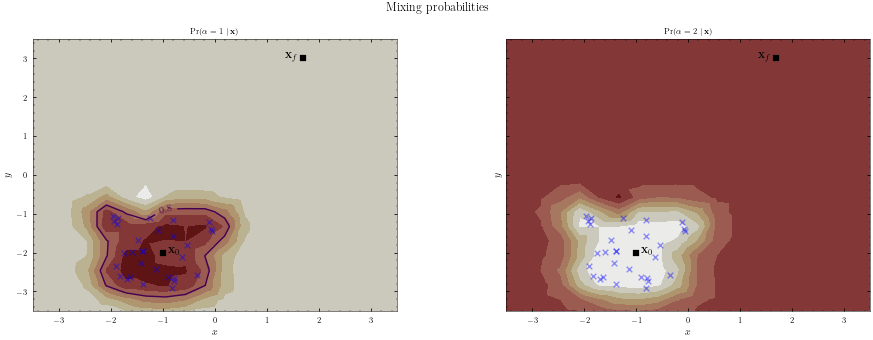

In [17]:
plot_mixing_probs(initial_states)
# plt.savefig("./images/initial_mixing_probs.pdf", transparent=True)
plt.savefig(os.path.join(save_dir, "initial_mixing_prob.pdf"), transparent=True)
# plt.savefig("./velocity_controlled_point_mass/notebooks/images/initial_mixing_probs.pdf", transparent=True)

In [18]:
def sample_delta_mode_states(num_states_to_sample=100, delta_mode_prob=0.8, num_initial_samples=10):
    delta_mode_states = random.uniform([-4, -4], [4, 4], (num_initial_samples, state_dim))
    while delta_mode_states.shape[0] < num_states_to_sample:
        delta_mode_states = random.uniform([-4, -4], [4, 4], (num_initial_samples, state_dim))
        mixing_probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs(delta_mode_states)
        delta_mode_states = delta_mode_states[mixing_probs[:, desired_mode]>delta_mode_prob, :]
#         print("delta_mode_states.shape")
#         print(delta_mode_states.shape)
        num_initial_samples = num_initial_samples * 2
        if previous_mosvgpe is not None:
            mask = previous_mosvgpe.gating_network.predict_mixing_probs(delta_mode_states)[:, desired_mode] < delta_mode_prob
#             print("mask")
#             print(mask)
#             print(mask.shape)
            delta_mode_states = delta_mode_states[mask, :]
        if delta_mode_states.shape[0] == 0:
            delta_mode_prob -= 0.05
            print("Mode satisfaction probability being relaxed to {}".format(delta_mode_prob))
    return delta_mode_states[:num_states_to_sample, :]

# def sample_delta_mode_states(num_states_to_sample=100, delta_mode_prob=0.8, num_initial_samples=10):
#     delta_mode_states = random.uniform([-4, -4], [4, 4], (num_initial_samples, state_dim))
#     while delta_mode_states.shape[0] < num_states_to_sample:
#         delta_mode_states = random.uniform([-4, -4], [4, 4], (num_initial_samples, state_dim))
#         mixing_probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs(delta_mode_states)
#         delta_mode_states = delta_mode_states[mixing_probs[:, desired_mode]>delta_mode_prob, :]
#         num_initial_samples = num_initial_samples * 2
#         if delta_mode_states.shape[0] == 0:
#             delta_mode_prob -= 0.05
#             print("Mode satisfaction probability being relaxed to {}".format(delta_mode_prob))
#     return delta_mode_states[:num_states_to_sample, :]

def sample_delta_mode_remaining_state_control_inputs(dataset, 
                                                     delta_mode_prob, 
                                                     previous_mosvgpe=None, 
                                                     num_states_to_sample=100):
    X, Y = dataset 
    states = X[:, :state_dim]
    delta_mode_states = sample_delta_mode_states(num_states_to_sample, delta_mode_prob)
    if previous_mosvgpe is None:
        mask_x_min = delta_mode_states[:, 0]<states[:, 0].min(0) 
        mask_x_max = delta_mode_states[:, 0]>states[:, 0].max(0)
        mask_y_min = delta_mode_states[:, 1]<states[:, 1].min(0) 
        mask_y_max = delta_mode_states[:, 1]>states[:, 1].max(0)
        mask = mask_x_min | mask_x_max | mask_y_min | mask_y_max
        delta_mode_states_keep = delta_mode_states[mask]
    else:
        delta_mode_states_keep = delta_mode_states
#     else:
#         mask = previous_mosvgpe.gating_network.predict_mixing_probs(delta_mode_states)[:, desired_mode] > delta_mode_prob
#         print(mask)
#         print(mask.shape)
#     delta_mode_states_keep = delta_mode_states[mask]
#     delta_mode_states_keep = delta_mode_states
    print(delta_mode_states_keep.shape)
    new_dataset = sample_env_at_states(delta_mode_states_keep)
    return new_dataset

In [19]:
def update_dataset(dataset, new_data):
    Xold, Yold = dataset
    Xnew, Ynew = new_data
    X = np.concatenate([Xold, Xnew], 0)
    Y = np.concatenate([Yold, Ynew], 0)
    return (X, Y)

In [20]:
# def mode_opt_step(dataset, mode_satisfaction_prob, step, previous_mosvgpe=None, num_states_to_sample=100):
#     new_dataset = sample_delta_mode_remaining_state_control_inputs(dataset, 
#                                                                    delta_mode_prob=mode_satisfaction_prob, 
#                                                                    previous_mosvgpe=previous_mosvgpe,
#                                                                    num_states_to_sample=num_states_to_sample)
#     dataset = update_dataset(dataset, new_dataset)
# #     history = mode_optimiser.dynamics.fit(dataset[0], dataset[1], epochs=num_epochs, batch_size=batch_size, verbose=False)
#     history = mode_optimiser.dynamics.fit(dataset[0], dataset[1], epochs=2, batch_size=batch_size, verbose=False)
#     clear_output(True)
#     plt.figure(figsize=[16, 8])
#     plt.subplot(1, 2, 1)
#     plt.title("Mean ELBO = %.3f" % -np.mean(np.array(history.history['loss'][-32:])))
#     plt.scatter(np.arange(len(history.history['loss'])), np.array(history.history['loss'])*-1.0)
#     plt.grid()
#     plt.show()
#     previous_mosvgpe = MixtureOfSVGPExperts.from_config(mode_optimiser.dynamics.mosvgpe.get_config())
#     return previous_mosvgpe, dataset

/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


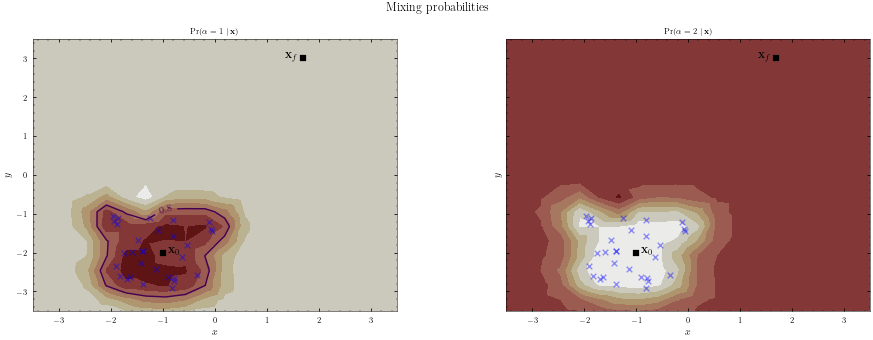

In [21]:
plot_mixing_probs(initial_states)
# plt.savefig("./images/mixing_probs_expanded_step{}.pdf".format(1), transparent=True)
# plot_mixing_probs(initial_states)
# plt.savefig("./images/mixing_probs_with_new_data_step{}.pdf".format(1), transparent=True)

In [22]:
# previous_mosvgpe = None  # used to make sure new samples are in new region
# num_states_to_sample = 100
# new_dataset = sample_delta_mode_remaining_state_control_inputs(dataset, 
#                                                                    delta_mode_prob=mode_satisfaction_prob, 
#                                                                    previous_mosvgpe=previous_mosvgpe,
#                                                                    num_states_to_sample=num_states_to_sample)
# previous_mosvgpe = MixtureOfSVGPExperts.from_config(mode_optimiser.dynamics.mosvgpe.get_config())
# plot_mixing_probs(new_dataset[0])
# updated_dataset = update_dataset(dataset, new_dataset)
# history = mode_optimiser.dynamics.fit(updated_dataset[0], 
#                                       updated_dataset[1], 
#                                       epochs=num_epochs, 
#                                       batch_size=batch_size)
# #                                       verbose=False
# #                                       callbacks=PlottingCallback())
# plot_mixing_probs(new_dataset[0])
# plot_mixing_probs(updated_dataset[0])

In [23]:
# new_dataset_2 = sample_delta_mode_remaining_state_control_inputs(dataset, 
#                                                                    delta_mode_prob=mode_satisfaction_prob, 
#                                                                    previous_mosvgpe=previous_mosvgpe,
#                                                                    num_states_to_sample=num_states_to_sample)
# plot_mixing_probs(new_dataset_2[0])

In [24]:
logging_epoch_freq = 30
class PlottingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % logging_epoch_freq == 0:
    #         clear_output(True)
#             plt.figure(figsize=[16, 8])
#             plt.subplot(1, 2, 1)
    #         plt.title("Mean ELBO = %.3f" % -np.mean(np.array(logs['loss'][-32:])))
#             plt.scatter(np.arange(len(logs['loss'])), np.array(logs['loss'])*-1.0)
#             plt.grid()
            plot_mixing_probs(dataset[0])
            save_filename = os.path.join(save_dir,"mixing_probs_expanded_step{}_epoch{}.pdf".format(step, epoch))
            plt.savefig(save_filename, transparent=True)
#             plt.savefig("./images/mixing_probs_expanded_step{}_epoch{}.pdf".format(step, epoch), transparent=True)
class CustomSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % logging_epoch_freq == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(os.path.join(save_dir, "ckpts/ModeOptDynamics".format(epoch)),
                            save_format="tf")
callbacks = [PlottingCallback(),
             CustomSaver(),
#              tf.keras.callbacks.ModelCheckpoint(
#                  filepath=os.path.join(save_dir + "ckpts/ModeOptDynamics"),
#                  monitor="loss",
#                  save_format="tf",
#                  save_best_only=False,
#                  save_freq=500),
             tf.keras.callbacks.TensorBoard(log_dir=os.path.join(save_dir, "logs"))
            ]

2022-02-27 21:55:51.631169: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-27 21:55:51.631187: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-27 21:55:51.632643: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Mode satisfaction probability being relaxed to 0.75
(11, 2)


2022-02-27 21:55:52.817723: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-27 21:55:52.817743: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-27 21:55:52.828593: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-27 21:55:52.838947: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-27 21:55:52.849632: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_21_55_52

2022-02-27 21:55:52.857404: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_21_55_52/dr-robots-mbp.trace.json.gz
2022-02-27 21:55:52.882540: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/202

Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.
INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets
Mode satisfaction probability being relaxed to 0.75
Mode satisfaction probability being relaxed to 0.7
(40, 2)


2022-02-27 21:56:44.889163: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-27 21:56:44.889182: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-27 21:56:44.899553: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-27 21:56:44.907949: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-27 21:56:44.913907: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_21_56_44

2022-02-27 21:56:44.918676: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_21_56_44/dr-robots-mbp.trace.json.gz
2022-02-27 21:56:44.937391: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/202

INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets
(40, 2)


2022-02-27 21:57:58.217103: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-27 21:57:58.217123: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-27 21:57:58.229392: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-27 21:57:58.240281: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-27 21:57:58.247901: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_21_57_58

2022-02-27 21:57:58.253992: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_21_57_58/dr-robots-mbp.trace.json.gz
2022-02-27 21:57:58.277196: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/202

INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets
(40, 2)


2022-02-27 21:59:31.699254: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-27 21:59:31.699275: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-27 21:59:31.712659: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-27 21:59:31.724224: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-27 21:59:31.732667: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_21_59_31

2022-02-27 21:59:31.739029: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_21_59_31/dr-robots-mbp.trace.json.gz
2022-02-27 21:59:31.762749: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/202

INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets
(40, 2)


2022-02-27 22:01:27.867884: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-27 22:01:27.867907: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-27 22:01:27.881025: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-27 22:01:27.893548: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-27 22:01:27.902257: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_01_27

2022-02-27 22:01:27.909273: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_01_27/dr-robots-mbp.trace.json.gz
2022-02-27 22:01:27.935567: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/202

INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets
Mode satisfaction probability being relaxed to 0.75
Mode satisfaction probability being relaxed to 0.7
Mode satisfaction probability being relaxed to 0.6499999999999999
(40, 2)


2022-02-27 22:03:45.434288: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-27 22:03:45.434311: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-27 22:03:45.447574: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-27 22:03:45.460237: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-27 22:03:45.469283: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_03_45

2022-02-27 22:03:45.476431: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_03_45/dr-robots-mbp.trace.json.gz
2022-02-27 22:03:45.502616: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/202

INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets
Mode satisfaction probability being relaxed to 0.75
(40, 2)


2022-02-27 22:06:23.832507: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-27 22:06:23.832527: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-27 22:06:23.843504: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-27 22:06:23.852926: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-27 22:06:23.859609: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_06_23

2022-02-27 22:06:23.864827: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_06_23/dr-robots-mbp.trace.json.gz
2022-02-27 22:06:23.884833: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/202

INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets
Mode satisfaction probability being relaxed to 0.75
Mode satisfaction probability being relaxed to 0.7
(40, 2)


2022-02-27 22:09:06.635128: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-27 22:09:06.635148: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-27 22:09:06.648084: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-27 22:09:06.659398: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-27 22:09:06.667305: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_09_06

2022-02-27 22:09:06.673622: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_09_06/dr-robots-mbp.trace.json.gz
2022-02-27 22:09:06.696503: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/202

INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets
Mode satisfaction probability being relaxed to 0.75
(40, 2)


2022-02-27 22:12:07.727015: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-27 22:12:07.727037: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-27 22:12:07.739906: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-27 22:12:07.751053: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-27 22:12:07.759000: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_12_07

2022-02-27 22:12:07.765134: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_12_07/dr-robots-mbp.trace.json.gz
2022-02-27 22:12:07.788527: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/202

INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets
Mode satisfaction probability being relaxed to 0.75
(40, 2)


2022-02-27 22:15:27.162895: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-27 22:15:27.162914: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-27 22:15:27.175718: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-27 22:15:27.187283: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-27 22:15:27.197179: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_15_27

2022-02-27 22:15:27.203668: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_15_27/dr-robots-mbp.trace.json.gz
2022-02-27 22:15:27.227131: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/202

INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets
Mode satisfaction probability being relaxed to 0.75
(40, 2)


2022-02-27 22:19:05.736930: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-27 22:19:05.736951: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-27 22:19:05.750266: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-27 22:19:05.760661: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-27 22:19:05.768399: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_19_05

2022-02-27 22:19:05.774293: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_19_05/dr-robots-mbp.trace.json.gz
2022-02-27 22:19:05.797223: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/202

INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets
Mode satisfaction probability being relaxed to 0.75
(40, 2)


2022-02-27 22:23:02.150349: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-27 22:23:02.150370: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-27 22:23:02.163384: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-27 22:23:02.174523: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-27 22:23:02.183419: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_23_02

2022-02-27 22:23:02.189373: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_23_02/dr-robots-mbp.trace.json.gz
2022-02-27 22:23:02.212400: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/202

INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets
Mode satisfaction probability being relaxed to 0.75
Mode satisfaction probability being relaxed to 0.7
Mode satisfaction probability being relaxed to 0.6499999999999999
(40, 2)


2022-02-27 22:27:17.543225: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-27 22:27:17.543245: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-27 22:27:17.554877: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-27 22:27:17.564875: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-27 22:27:17.572779: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_27_17

2022-02-27 22:27:17.578445: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_27_17/dr-robots-mbp.trace.json.gz
2022-02-27 22:27:17.599329: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/202

INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets
Mode satisfaction probability being relaxed to 0.75
Mode satisfaction probability being relaxed to 0.7
Mode satisfaction probability being relaxed to 0.6499999999999999
Mode satisfaction probability being relaxed to 0.5999999999999999
(40, 2)


2022-02-27 22:31:52.828522: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-27 22:31:52.828542: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-27 22:31:52.840627: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-27 22:31:52.851909: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-27 22:31:52.860841: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_31_52

2022-02-27 22:31:52.867533: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./images/0.8/2022-02-27-21-52/logs/train/plugins/profile/2022_02_27_22_31_52/dr-robots-mbp.trace.json.gz
2022-02-27 22:31:52.892026: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./images/0.8/202

INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_68907/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


INFO:tensorflow:Assets written to: ./images/0.8/2022-02-27-21-52/ckpts/ModeOptDynamics/assets


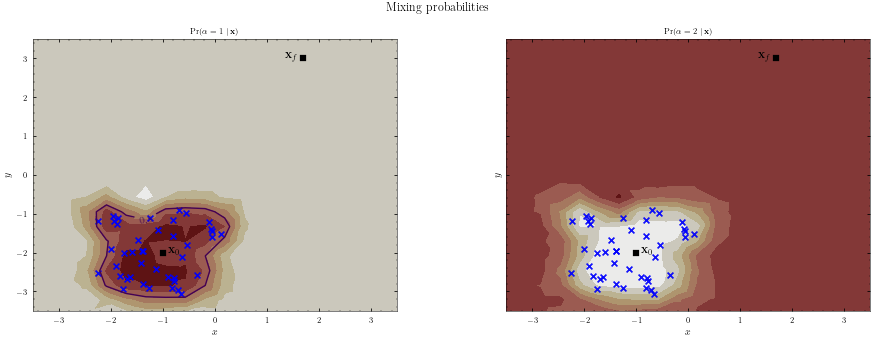

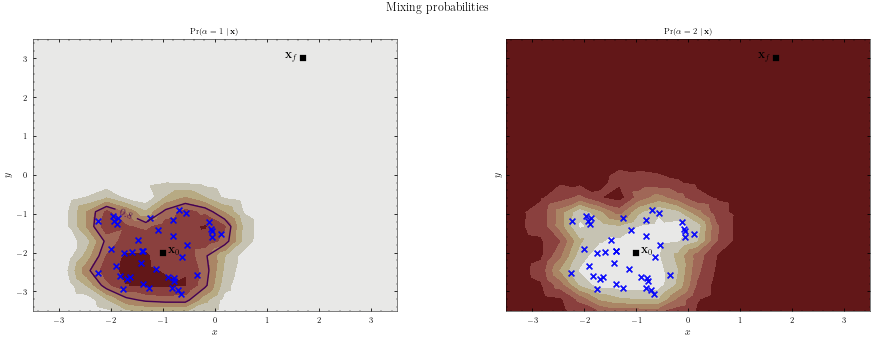

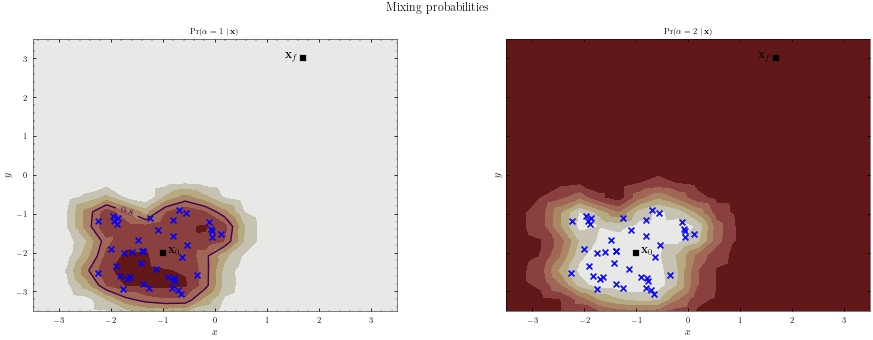

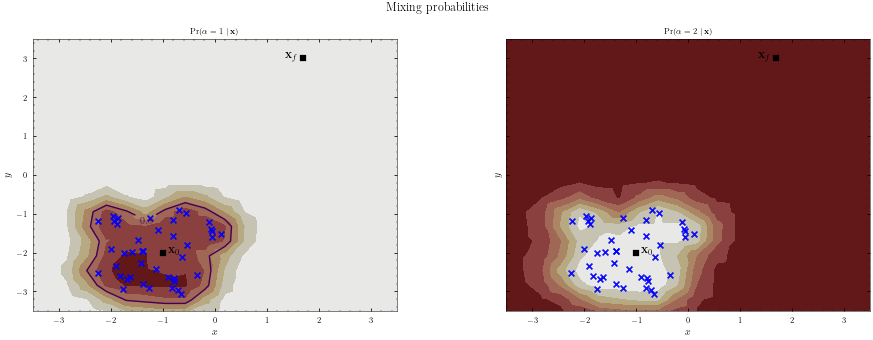

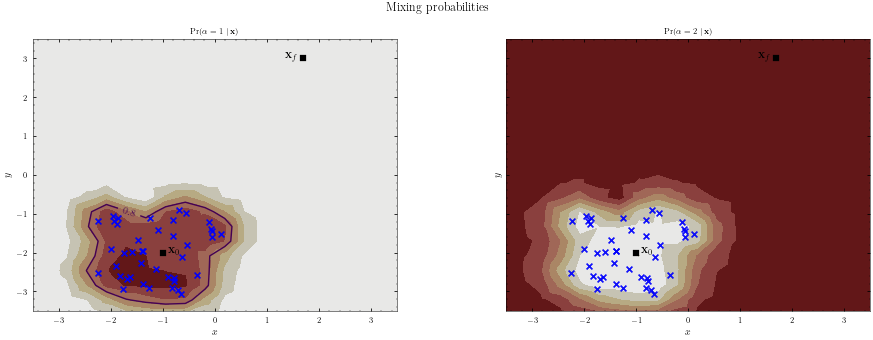

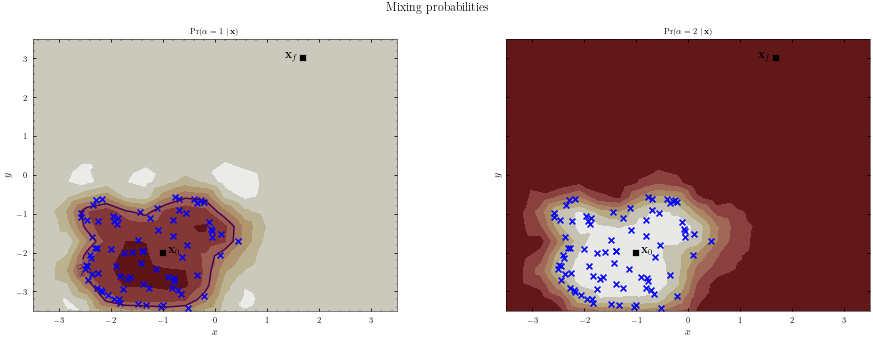

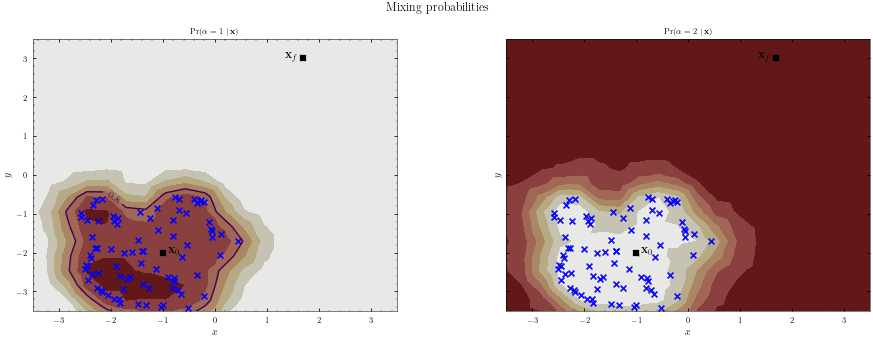

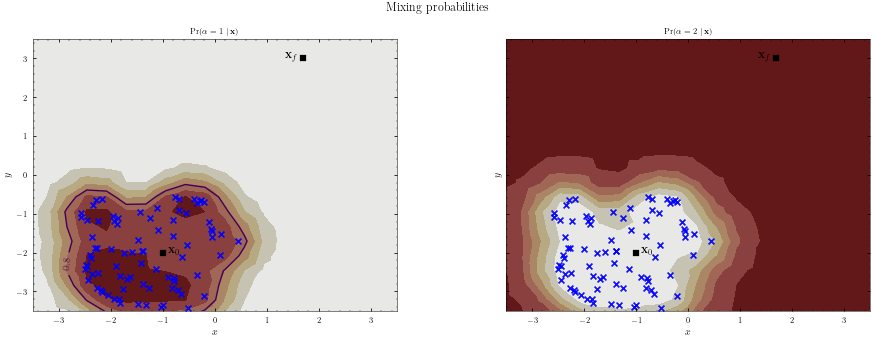

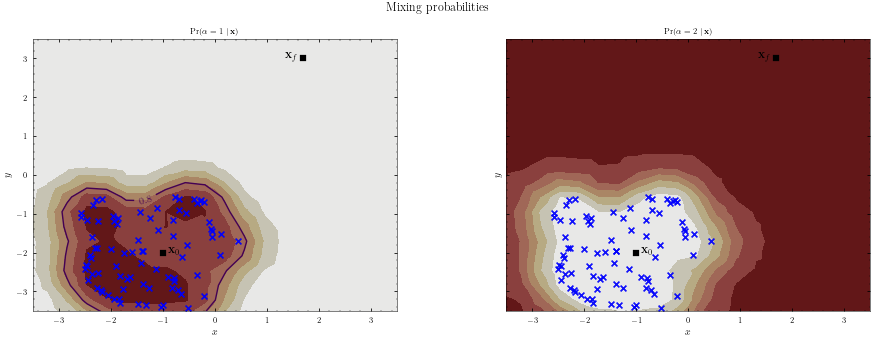

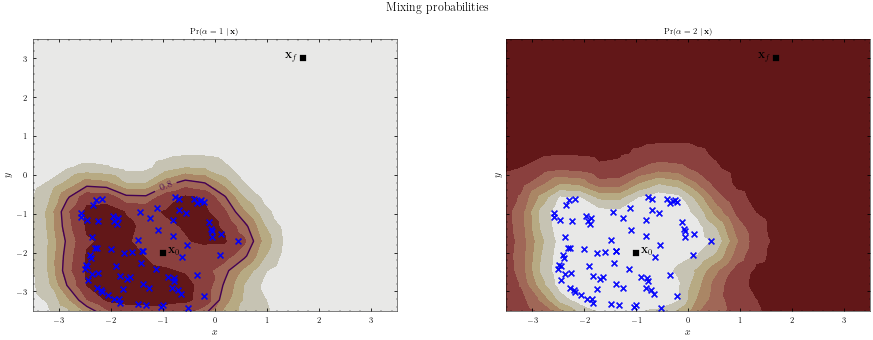

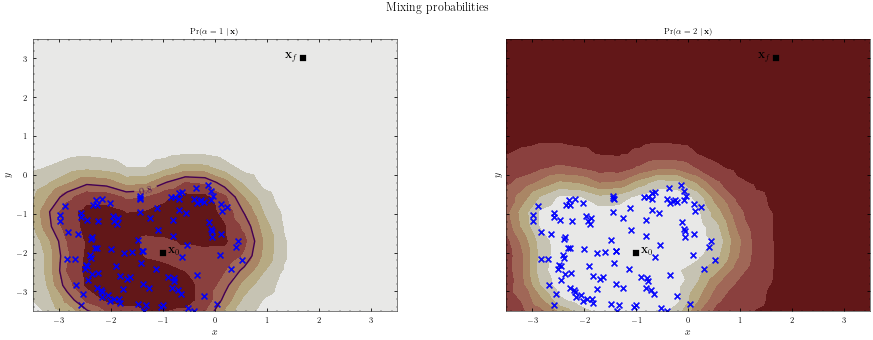

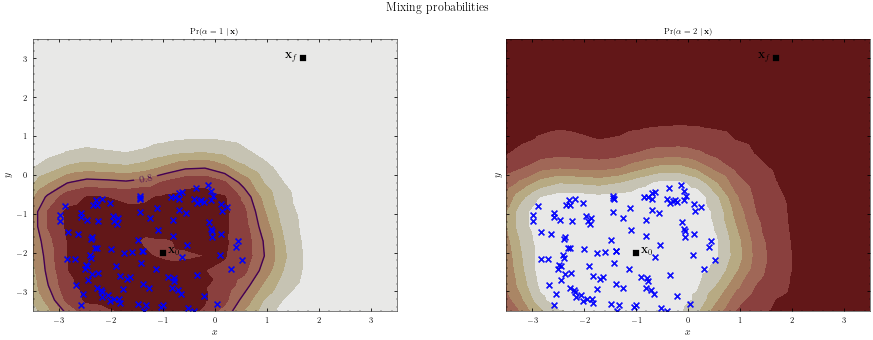

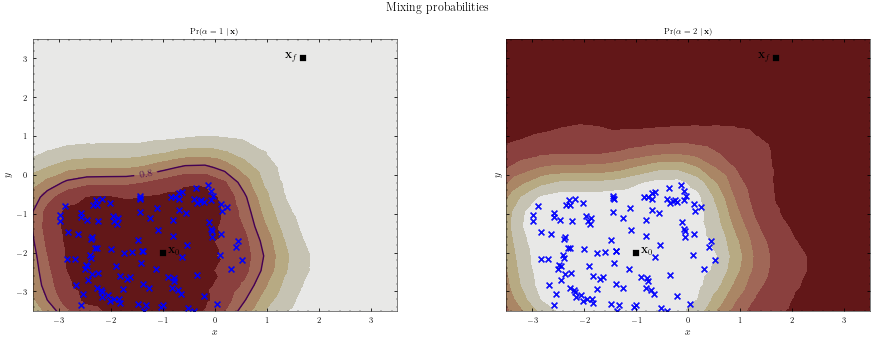

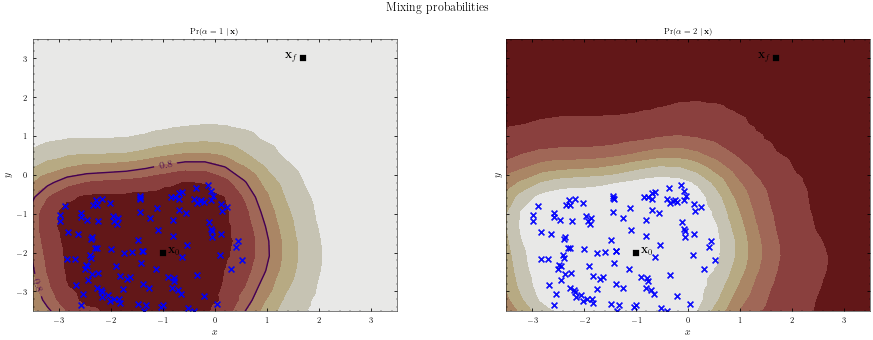

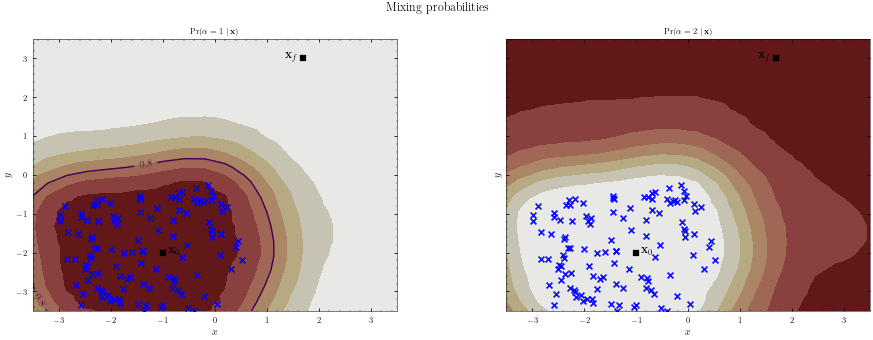

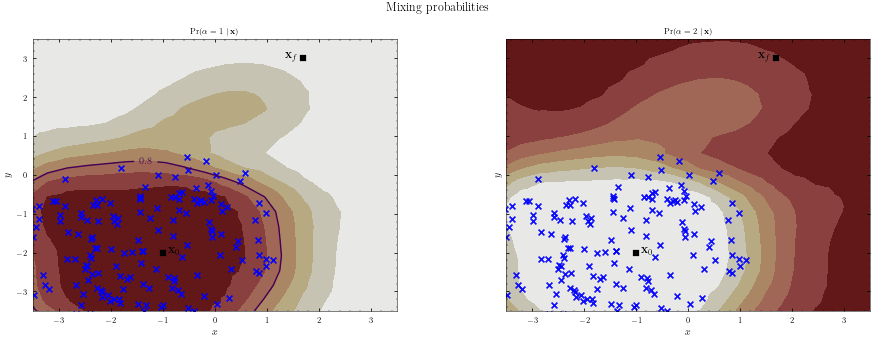

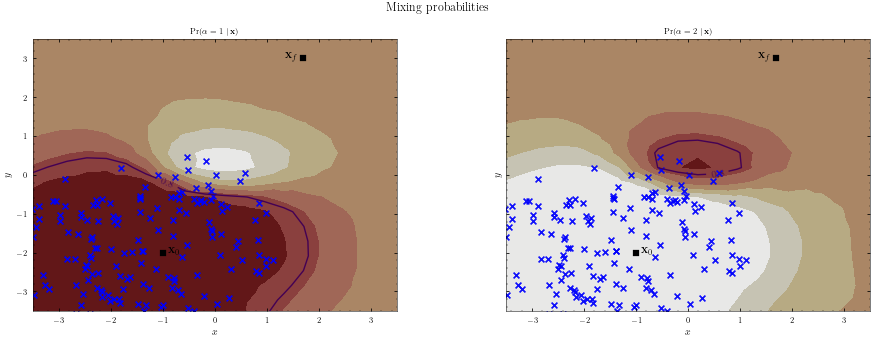

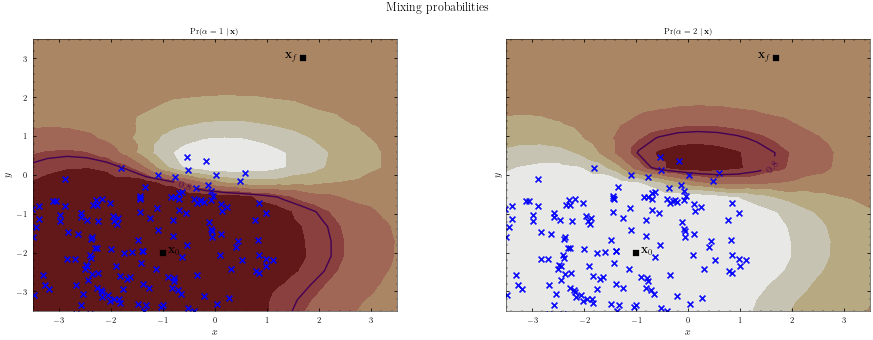

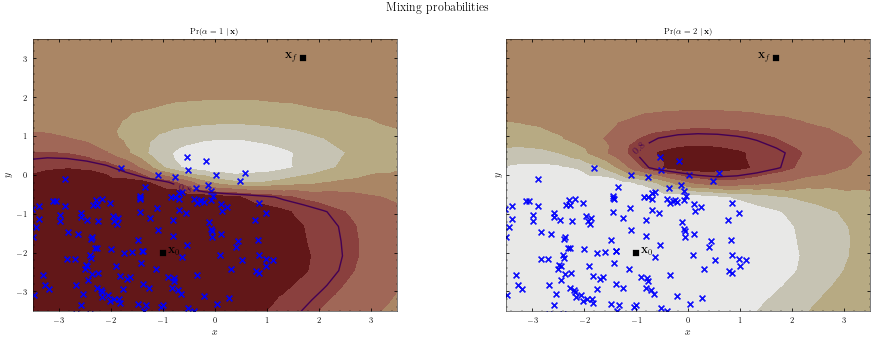

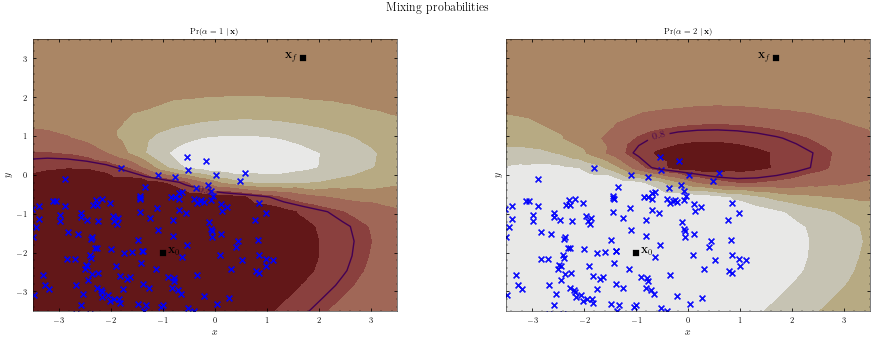

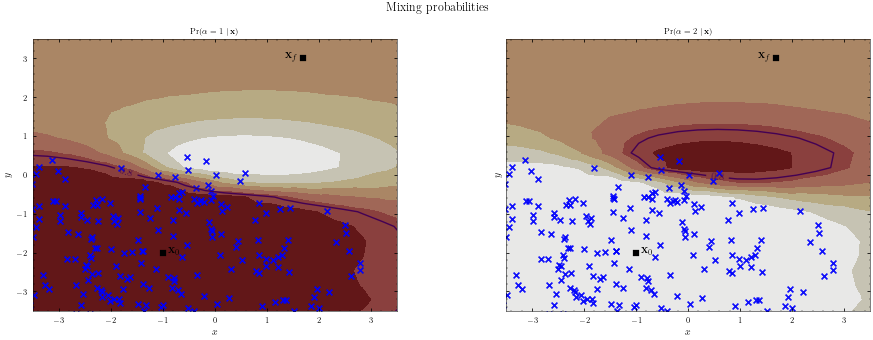

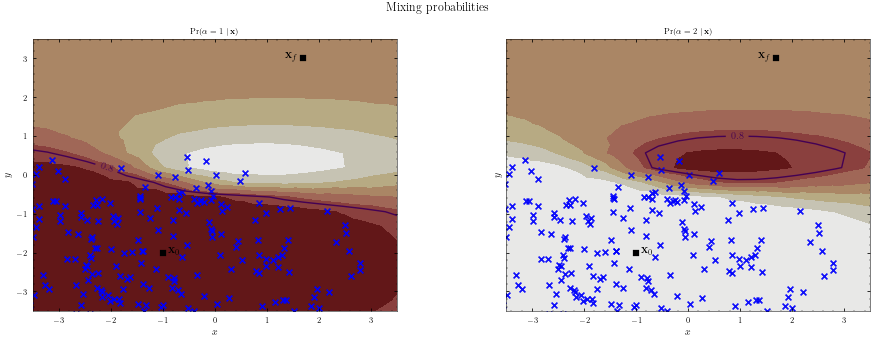

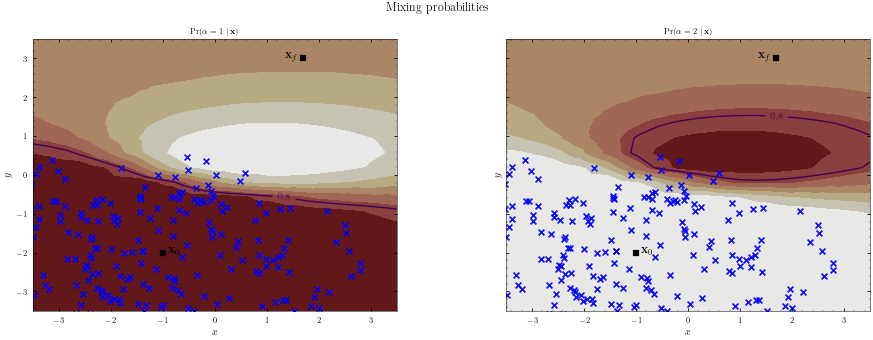

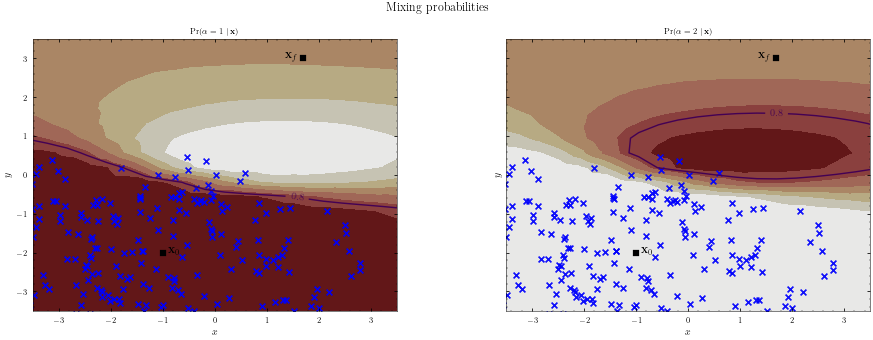

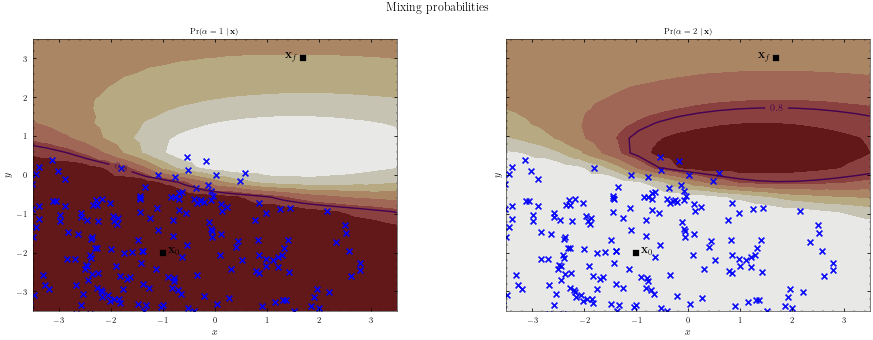

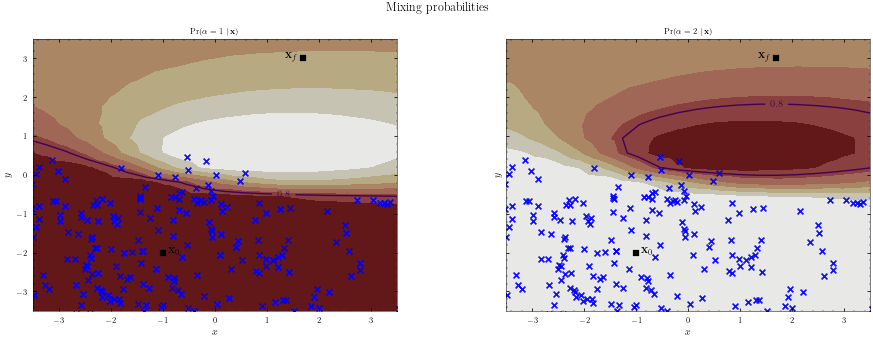

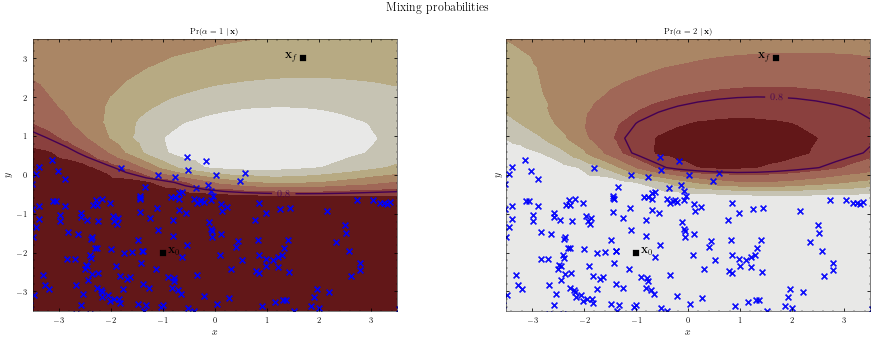

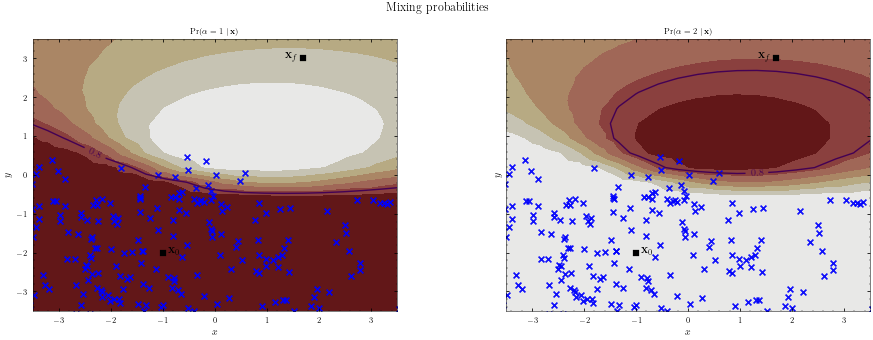

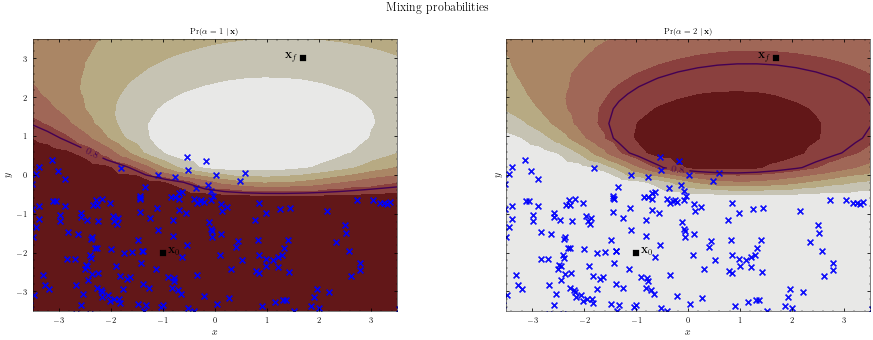

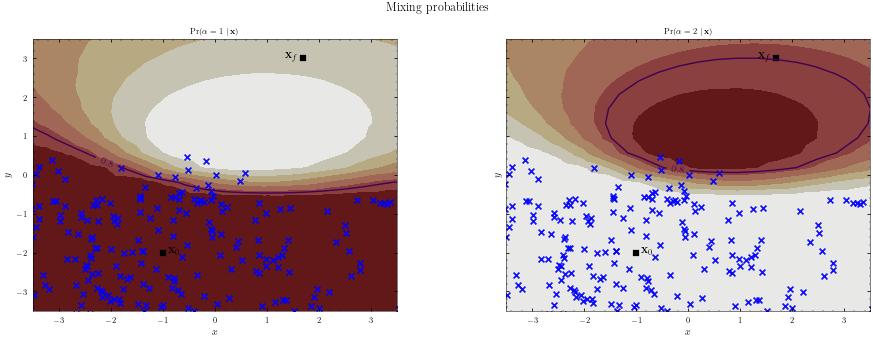

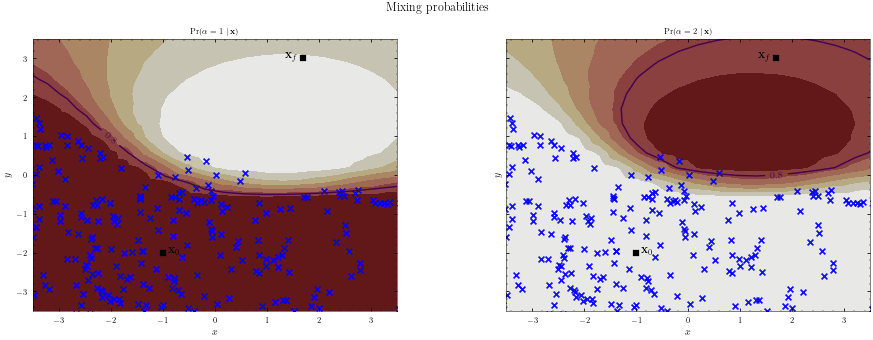

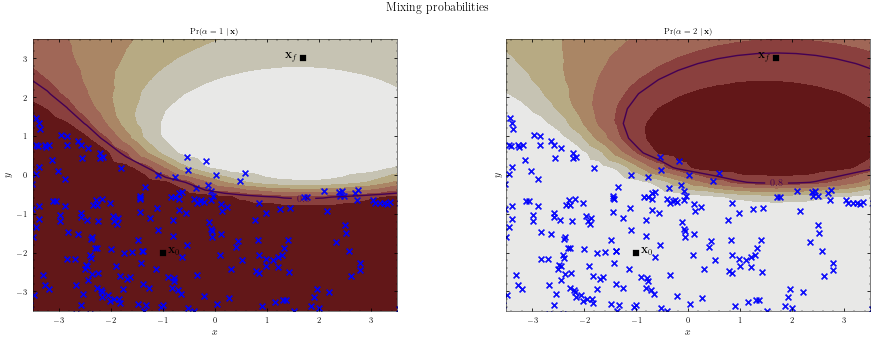

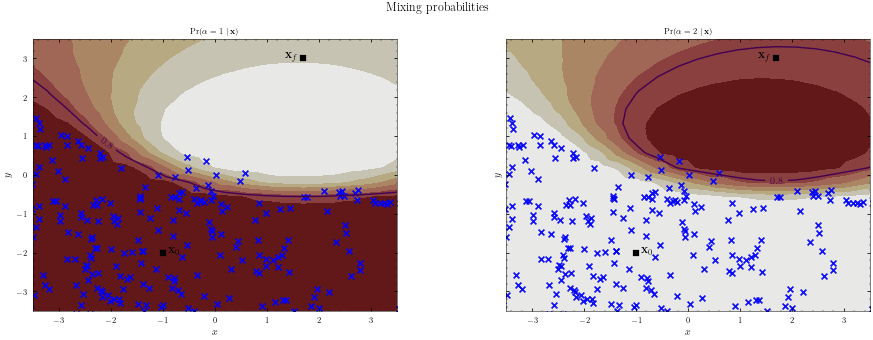

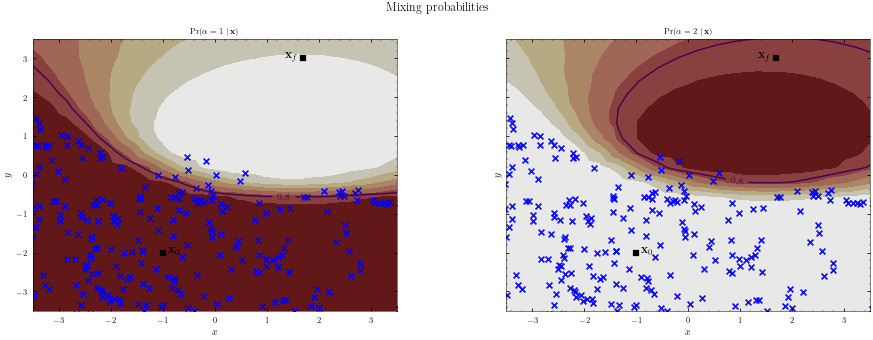

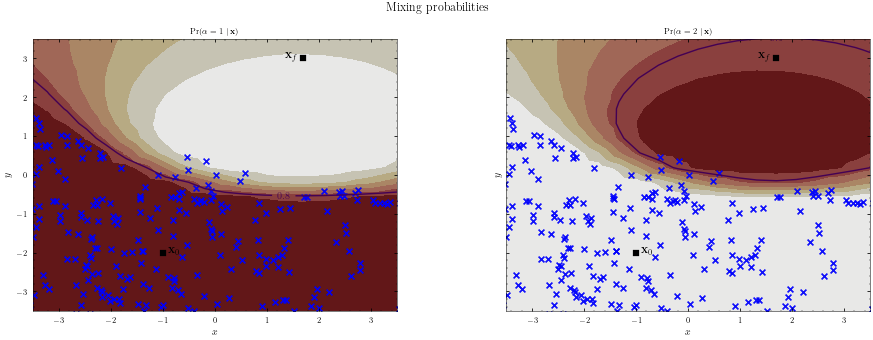

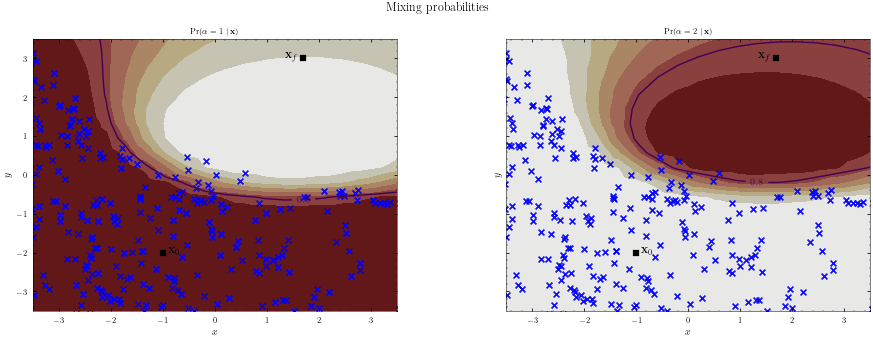

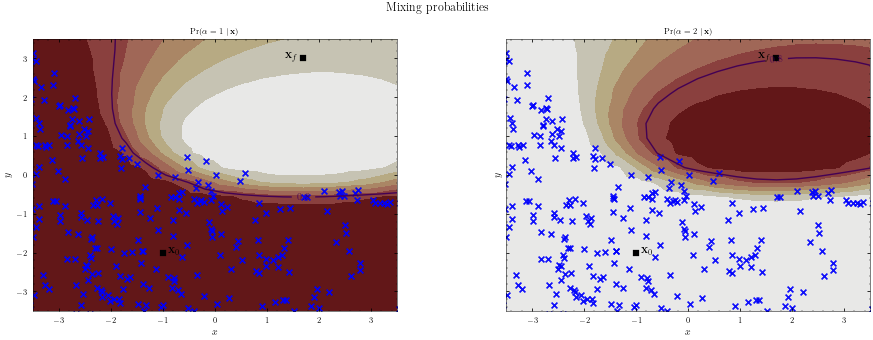

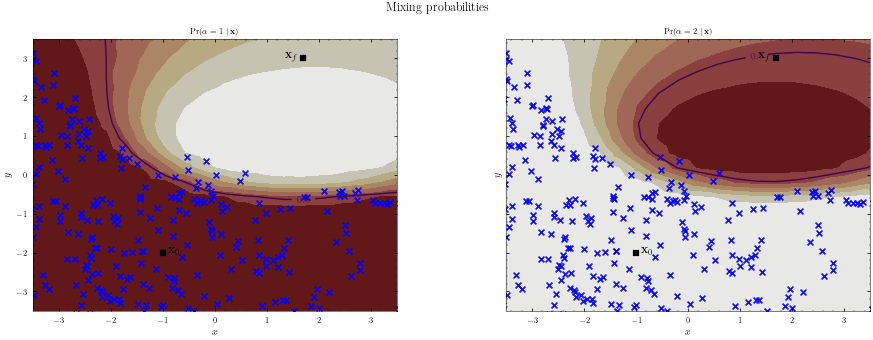

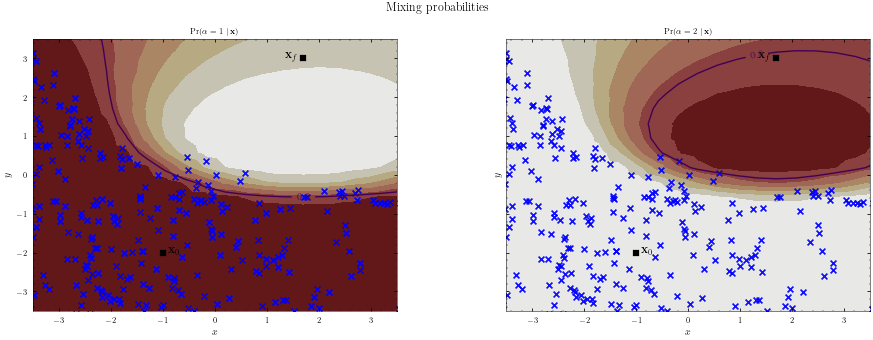

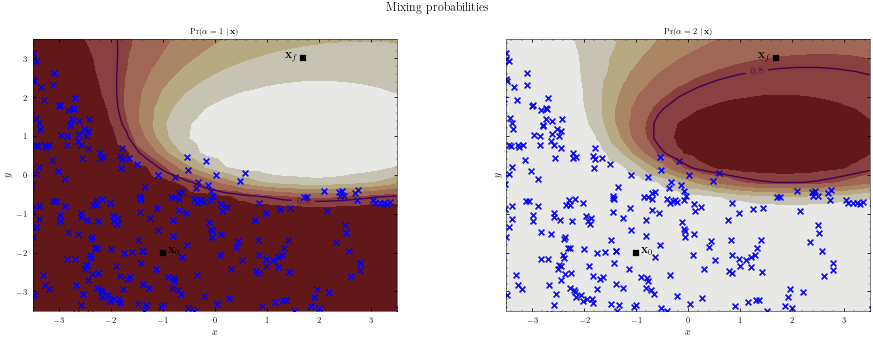

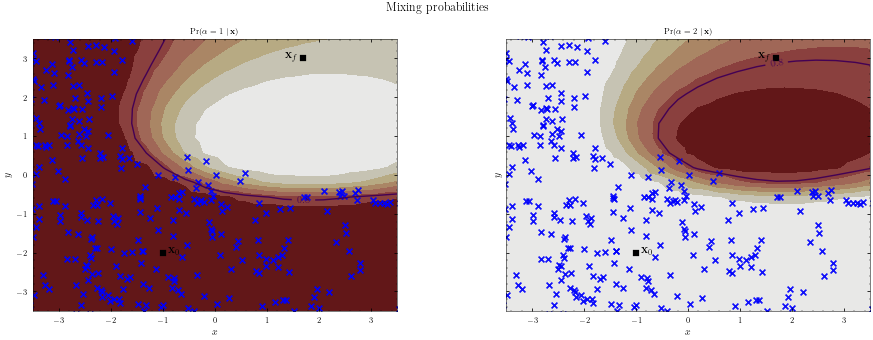

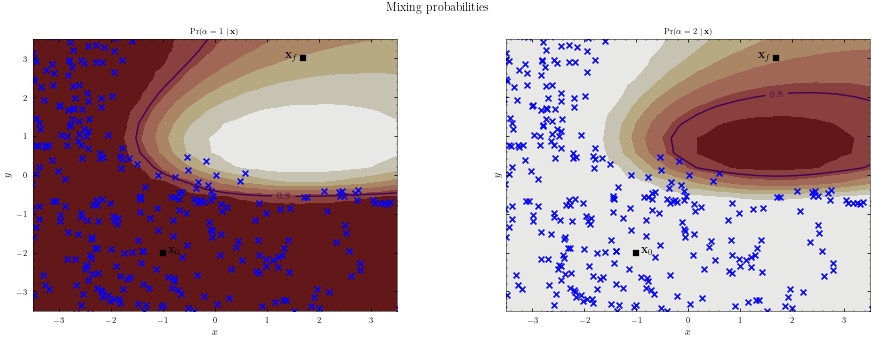

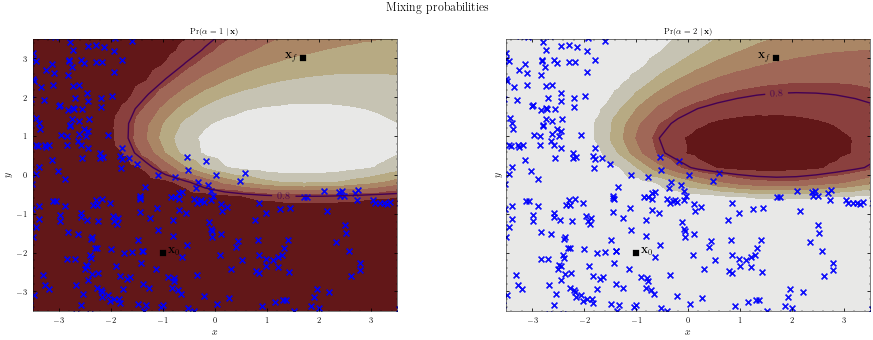

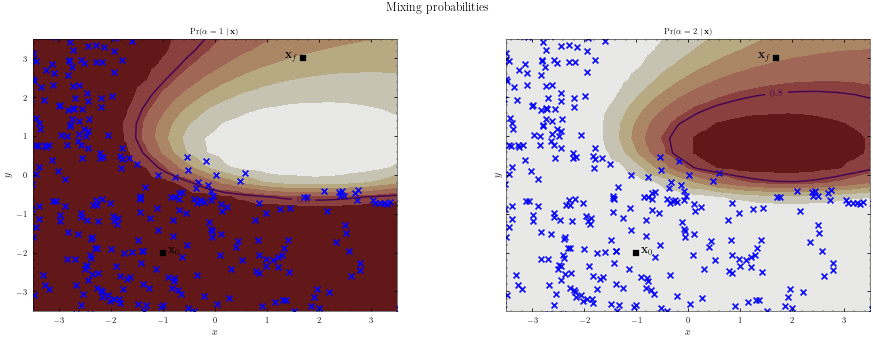

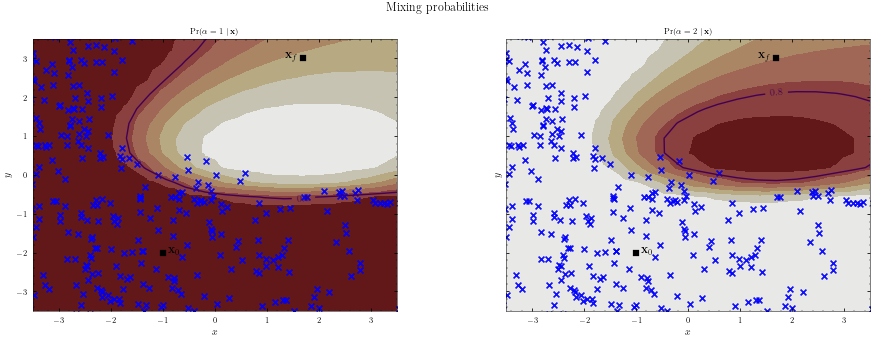

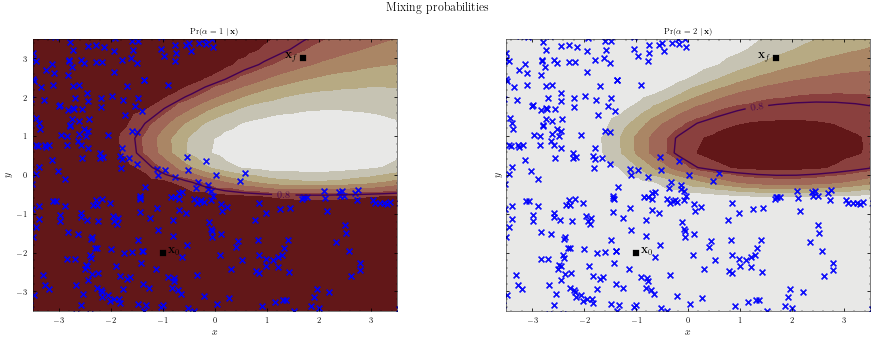

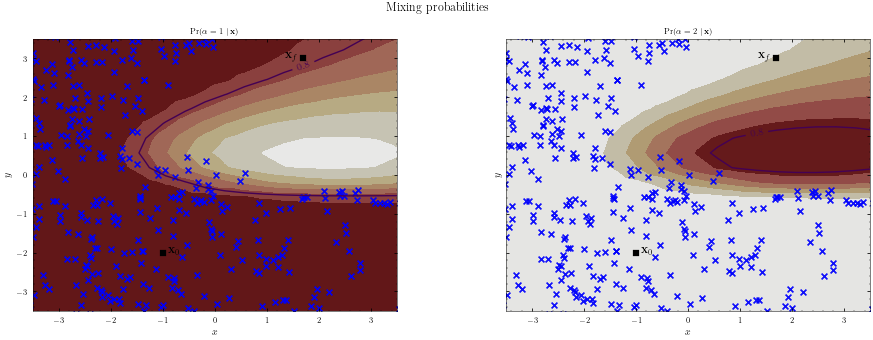

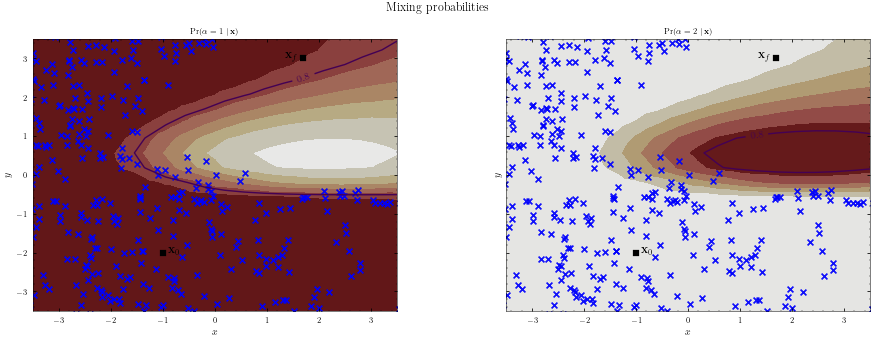

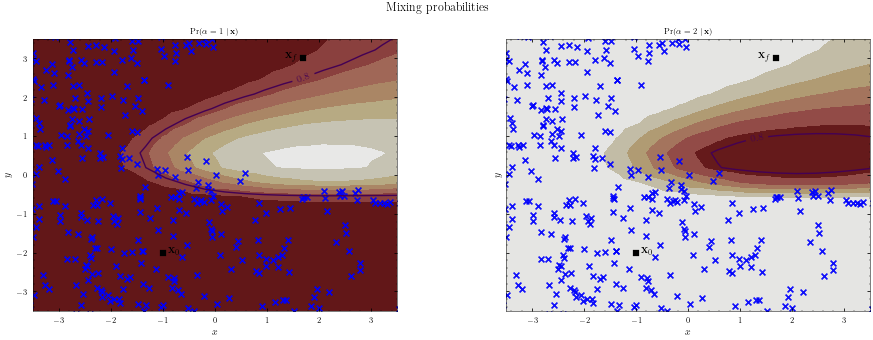

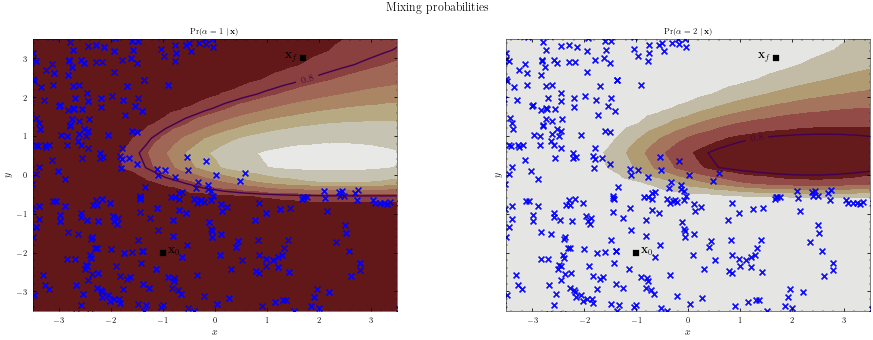

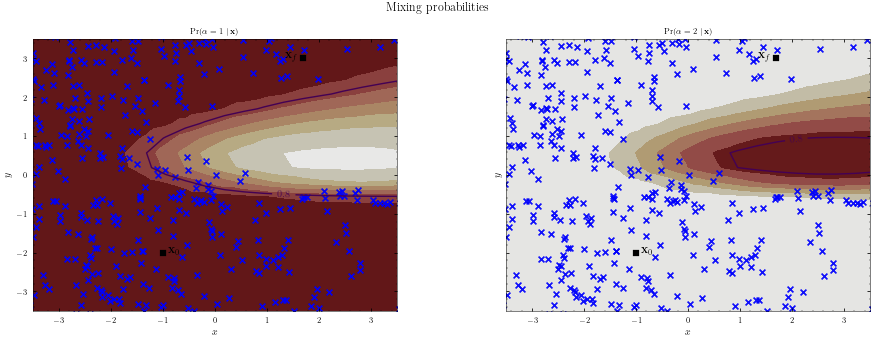

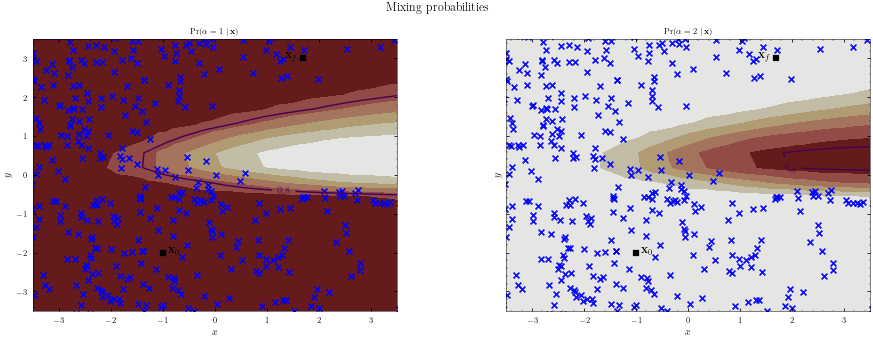

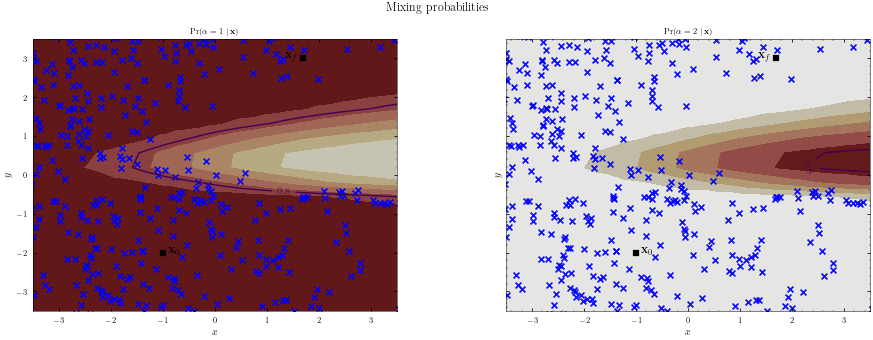

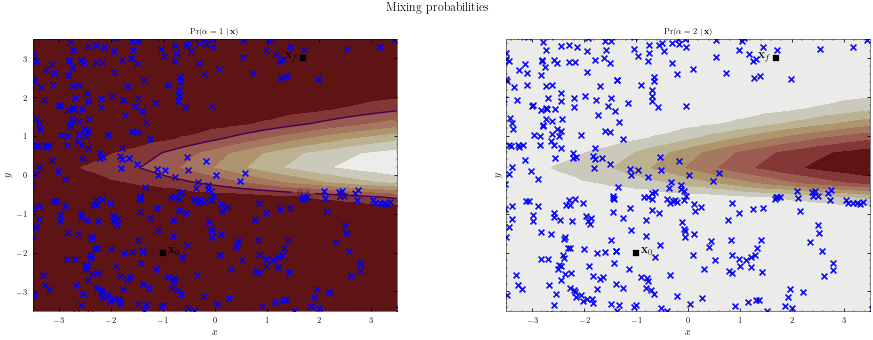

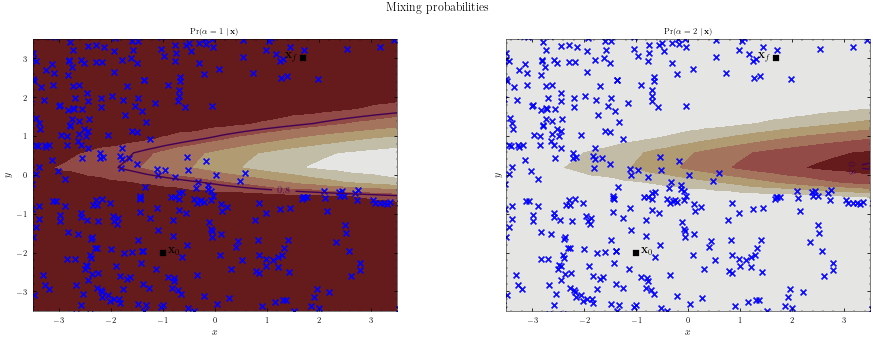

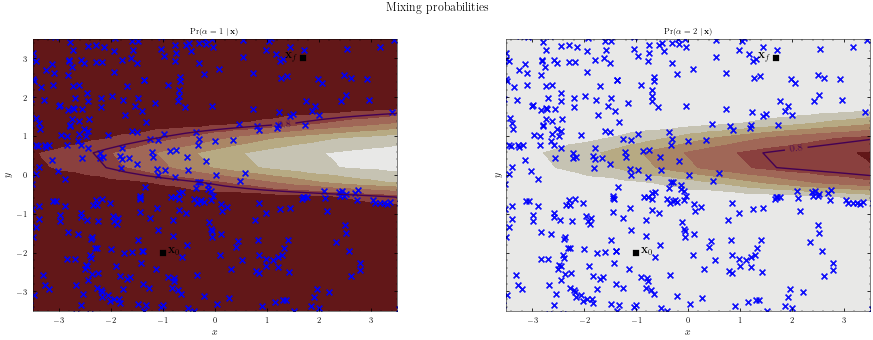

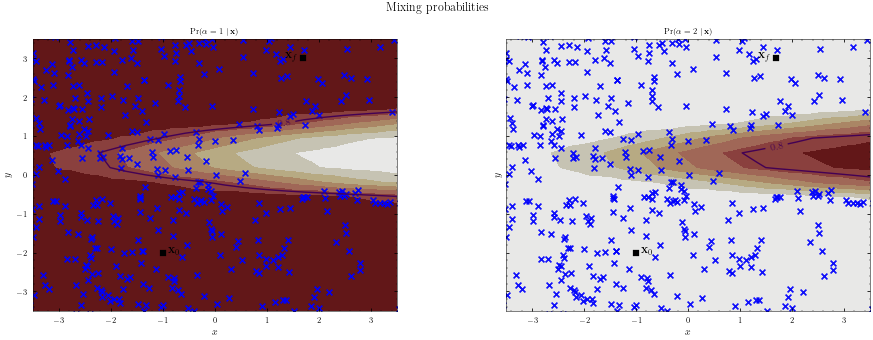

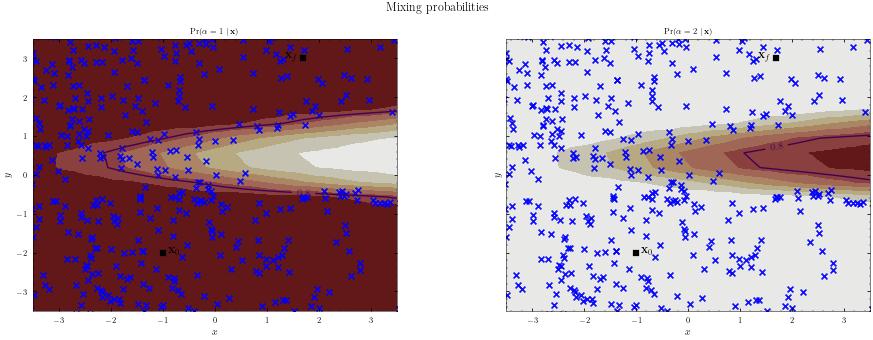

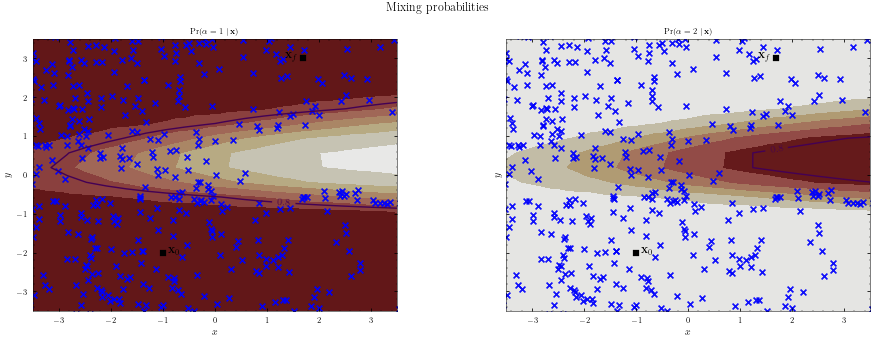

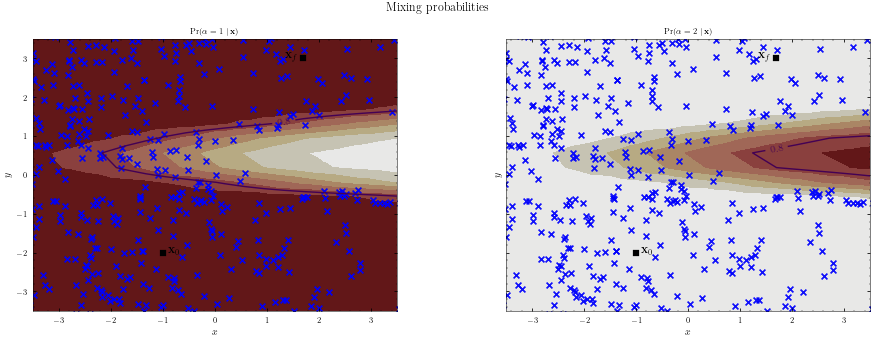

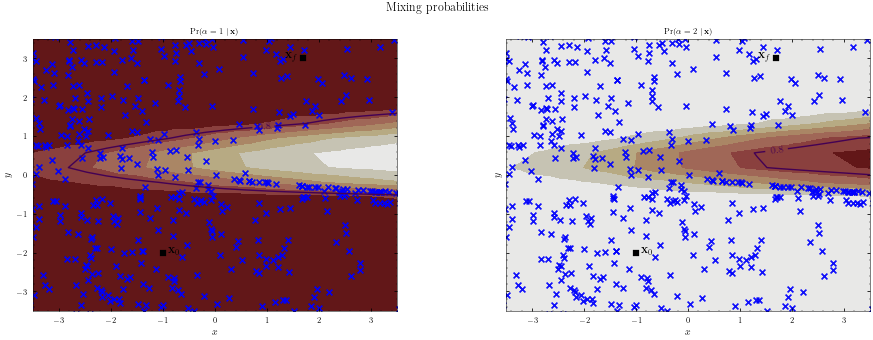

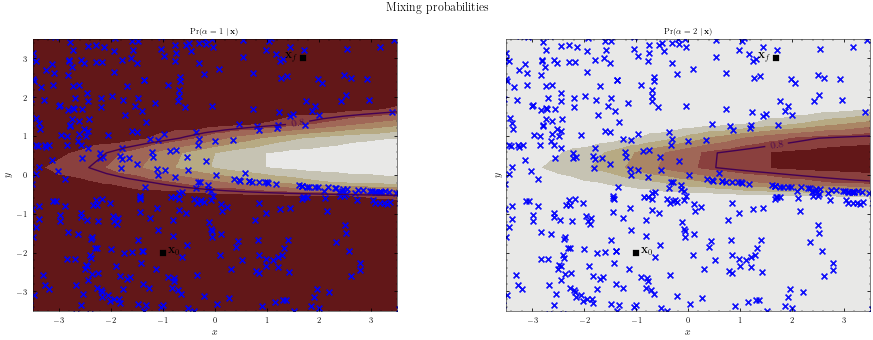

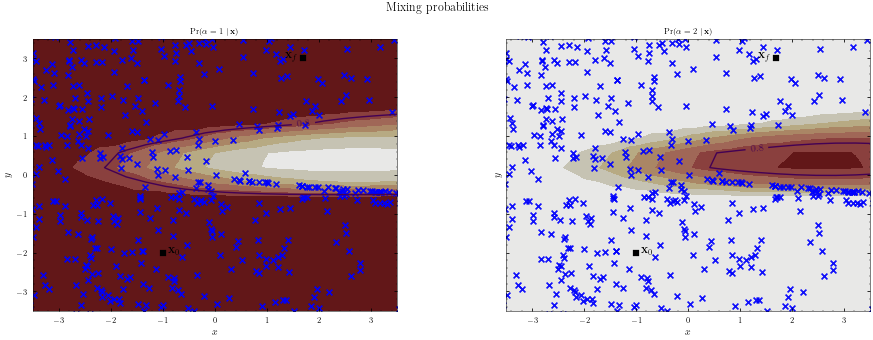

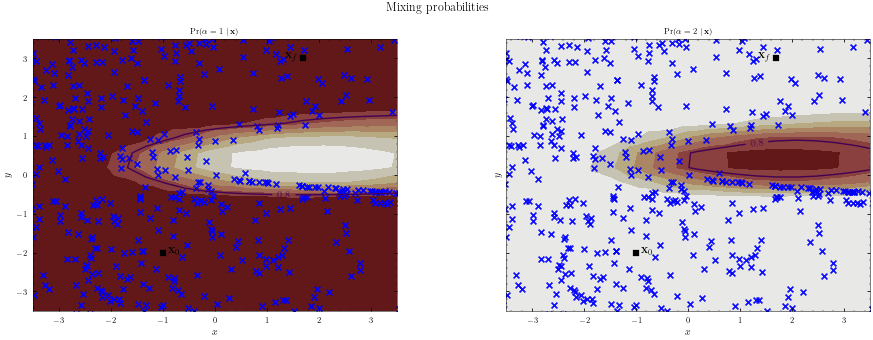

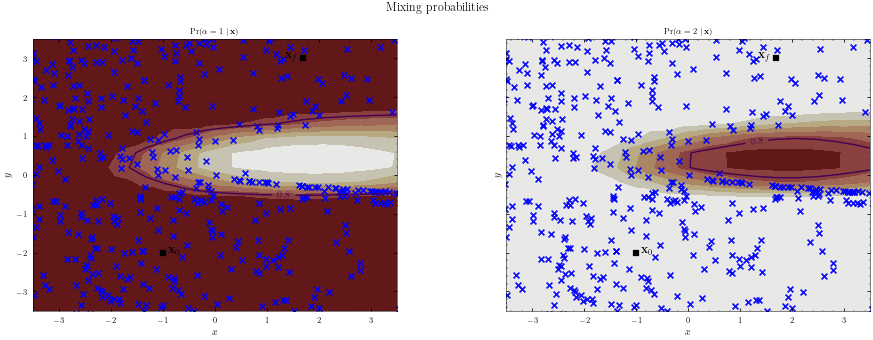

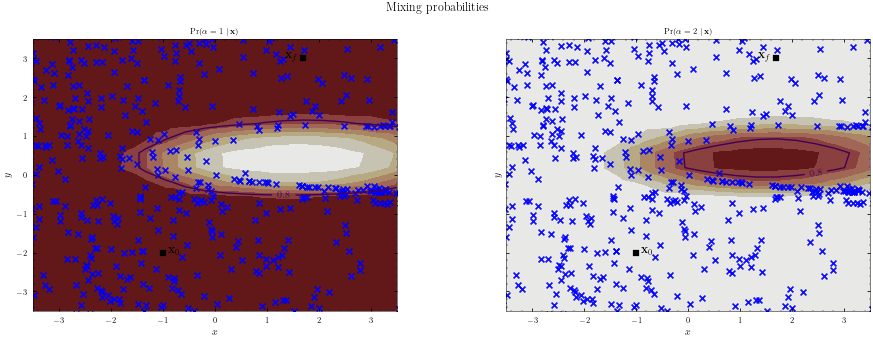

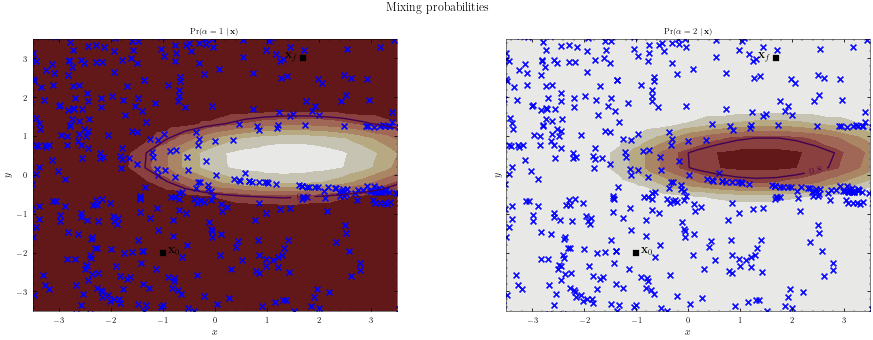

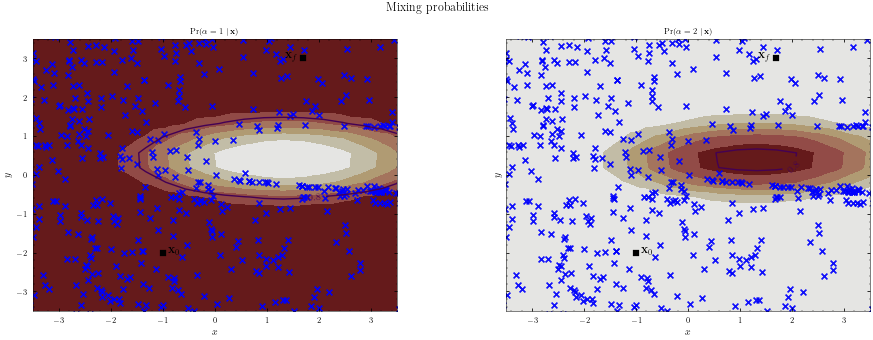

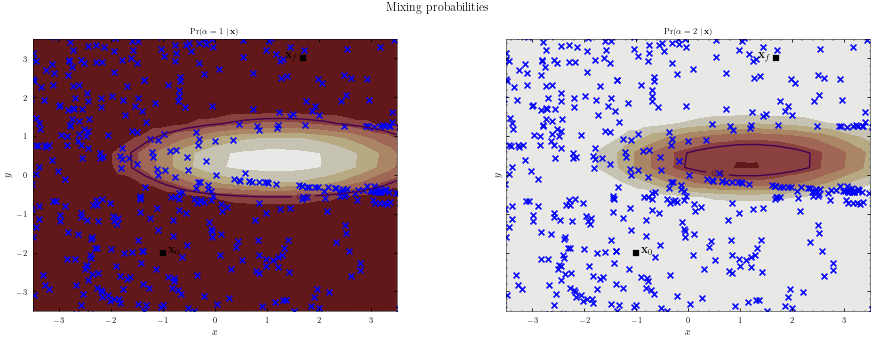

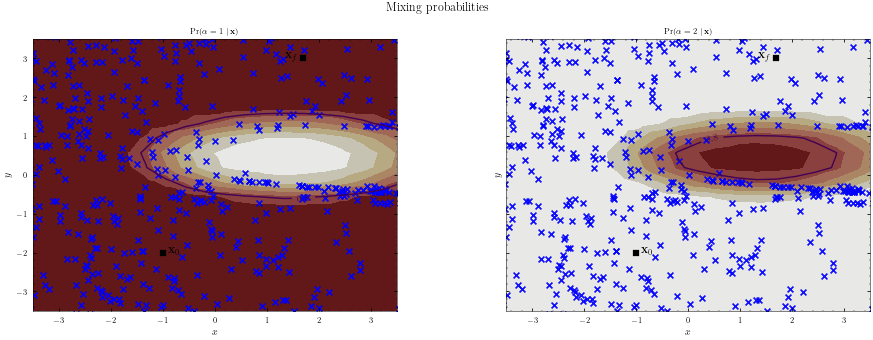

In [25]:
num_steps = 15
# num_states_to_sample = 100
num_states_to_sample = 40
mode_satisfaction_prob = 0.8
dataset = initial_dataset
previous_mosvgpe = None  # used to make sure new samples are in new region
mode_optimiser.dynamics(dataset[0]) # call ModeOptDynamics to build it for saving
for step in range(1, num_steps):
    new_dataset = sample_delta_mode_remaining_state_control_inputs(dataset, 
                                                                   delta_mode_prob=mode_satisfaction_prob, 
                                                                   previous_mosvgpe=previous_mosvgpe,
                                                                   num_states_to_sample=num_states_to_sample)
    dataset = update_dataset(dataset, new_dataset)
    previous_mosvgpe = MixtureOfSVGPExperts.from_config(mode_optimiser.dynamics.mosvgpe.get_config())
    history = mode_optimiser.dynamics.fit(dataset[0], 
                                          dataset[1], 
                                          epochs=num_epochs, 
                                          batch_size=batch_size, 
                                          verbose=False,
                                          callbacks=callbacks)
#                                           callbacks=PlottingCallback())
#     history = mode_optimiser.dynamics.fit(dataset[0], 
#                                           dataset[1], 
#                                           epochs=30, 
#                                           batch_size=batch_size, 
#                                           verbose=False, 
#                                           callbacks=PlottingCallback())
    
#     plot_mixing_probs(dataset[0])
#     plt.savefig("./images/mixing_probs_expanded_step{}.pdf".format(step), transparent=True)
#     plot_mixing_probs(dataset[0])
#     plt.savefig("./images/mixing_probs_with_new_data_step{}.pdf".format(step), transparent=True)
#     previous_dataset = dataset

In [ ]:
dataset = update_dataset(dataset, new_dataset)
plot_mixing_probs(dataset[0])

In [ ]:
mode_optimiser.dynamics.fit(dataset[0], dataset[1], epochs=num_epochs, batch_size=batch_size)

In [ ]:
plot_mixing_probs(dataset[0])